<a href="https://colab.research.google.com/github/cshgiser/HRSM/blob/main/HRSM_MAPPING_Sec2_ML_pipeline_multiplePoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial settings (authorize, connect GD, install packages, etc)

In [ ]:
# @title get GEE authorization
import ee

# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='ee-scai62')

In [ ]:
# @title Connect to my Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r '/content/gdrive/My Drive/NIFA_Download/StartFolder/CDL_sites/' .

In [ ]:
# @title Install necessary packages
!pip install folium
!pip install geopandas
!pip install netCDF4
!pip install --upgrade xee
!pip install rasterio
!pip install ipywidgets
!pip install permetrics==2.0.0
# !pip install pyDEM
# !pip install richdem
# !pip install pyflwdir
!pip install mapie
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.1/187.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 137.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 

In [ ]:
# @title Import packages
from mapie.regression import SplitConformalRegressor, ConformalizedQuantileRegressor
import lightgbm as lgb

import folium
from folium import Figure
import geopandas as gpd
import json
import geemap
import numpy as np
from shapely.geometry import mapping
import pandas as pd
import netCDF4 as nc
import xarray
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
import math
import time
import os
from datetime import datetime, timedelta
import joblib
import ipywidgets as widgets
from IPython.display import display
from permetrics import RegressionMetric
import osgeo.gdal as gdal
# import richdem as rd
# import pyflwdir
from osgeo import osr, gdalconst
from scipy.stats import rankdata

## Define study site: randomly choose points for each cropland based on CDL data

research paper: https://doi.org/10.1016/j.rse.2021.112445

In [ ]:
#@title request irrigation data

LANID2018_20 = ee.Image("users/xyhuwmir/LANID/update/LANID2018-2020")
LANID2016 = ee.Image("projects/ee-scai62/assets/lanid2016")
LANID2017 = ee.Image("projects/ee-scai62/assets/lanid2017")
LANID2018 = LANID2018_20.select('irMap18')
LANID2019 = LANID2018_20.select('irMap19')
LANID2020 = LANID2018_20.select('irMap20')
LANID_irrigation = (
    LANID2018.eq(1)
    .And(LANID2019.eq(1))
    .And(LANID2020.eq(1))
    .And(LANID2016.eq(1))
    .And(LANID2017.eq(1))
)

LANID_binary = ee.Image.constant(2).where(LANID_irrigation.eq(1), 1)

In [ ]:
#@title request climate data
koppen_geiger_COUNS_1991_2020 = ee.Image("projects/ee-scai62/assets/koppen_geiger_COUNS_1991_2020")

"""
14: Cfa  Temperate, no dry season, hot summer  [200 255 80]
25: Dfa  Cold, no dry season, hot summer       [0 255 255]

4:  BWh  Arid, desert, hot                     [255 0 0]
5:  BWk  Arid, desert, cold                    [255 150 150]
6:  BSh  Arid, steppe, hot                     [245 165 0]
7:  BSk  Arid, steppe, cold                    [255 220 100]


"""

koppen_reclassified = (
    koppen_geiger_COUNS_1991_2020
    .where(koppen_geiger_COUNS_1991_2020.eq(14), 1)
    .where(
        koppen_geiger_COUNS_1991_2020.eq(4)
        .Or(koppen_geiger_COUNS_1991_2020.eq(5))
        .Or(koppen_geiger_COUNS_1991_2020.eq(6))
        .Or(koppen_geiger_COUNS_1991_2020.eq(7)),
        2
    )
    .where(
        koppen_geiger_COUNS_1991_2020.neq(14)
        .And(koppen_geiger_COUNS_1991_2020.neq(4))
        .And(koppen_geiger_COUNS_1991_2020.neq(5))
        .And(koppen_geiger_COUNS_1991_2020.neq(6))
        .And(koppen_geiger_COUNS_1991_2020.neq(7)),
        0
    )
)
# print(koppen_reclassified.getInfo())

In [ ]:
# @title request CDL data in 2016 and 2017

# def maskCDL(img):
#   # Get the pixel QA band.
#   cropland = img.select('cropland')
#   confidence = img.select('confidence')
#   mask = confidence.gt(95).And(cropland.eq(1).Or(cropland.eq(5)).Or(cropland.eq(12)).Or(cropland.eq(13)).Or(cropland.eq(22)).Or(cropland.eq(23)).Or(cropland.eq(24)).Or(cropland.eq(43)))
#   return img.updateMask(mask).copyProperties(img, ['system:time_start'])

# """
# 1 - Corn
# 5 - Soybeans
# 12 - Sweet Corn
# 13 - Pop or Orn Corn
# 22 - Durum Wheat
# 23 - Spring Wheat
# 24 - Winter Wheat
# 43 - Potatoes

# """

# CDL = ee.ImageCollection("USDA/NASS/CDL")\
#             .filterDate('2016', '2018')\
#             .map(maskCDL)\
#             .select(['cropland'])


def maskCDL(img):
    cropland = img.select('cropland')
    confidence = img.select('confidence')

    # --- Reclassify specific crop types ---
    # Combine corn types (1, 12, 13) → 1 (Corn)
    cropland = cropland.where(cropland.eq(12), 1)
    cropland = cropland.where(cropland.eq(13), 1)

    # Combine wheat types (22, 23, 24) → 22 (Wheat)
    cropland = cropland.where(cropland.eq(23), 22)
    cropland = cropland.where(cropland.eq(24), 22)

    # Define mask: only pixels with high confidence (>95%) and relevant crop codes
    mask = (confidence.gt(90)
            .And(cropland.eq(1)
            .Or(cropland.eq(5))
            .Or(cropland.eq(22))
            .Or(cropland.eq(43))))

    # Return masked and reclassified image
    return img.addBands(cropland.rename('cropland'), overwrite=True) \
              .updateMask(mask) \
              .copyProperties(img, ['system:time_start'])


# Apply to CDL collection
CDL = (ee.ImageCollection("USDA/NASS/CDL")
       .filterDate('2016', '2024')
       .map(maskCDL)
       .select(['cropland']))


In [ ]:
# @title Print CDL image information
print(f'Number of CDL images: {CDL.size().getInfo()}')

# Get the list of images in the collection
image_list = CDL.toList(CDL.size())

# Iterate through the images and print the acquisition date
for i in range(CDL.size().getInfo()):
    image = ee.Image(image_list.get(i))
    date = ee.Date(image.get('system:time_start'))
    print(f'Image {i+1} acquired on: {date.format("YYYY-MM-dd").getInfo()}')

Number of CDL images: 8
Image 1 acquired on: 2016-01-01
Image 2 acquired on: 2017-01-01
Image 3 acquired on: 2018-01-01
Image 4 acquired on: 2019-01-01
Image 5 acquired on: 2020-01-01
Image 6 acquired on: 2021-01-01
Image 7 acquired on: 2022-01-01
Image 8 acquired on: 2023-01-01


In [ ]:
#@title Reduce to one image: only keep the pixels where the crop type did not change all the time
CDL2016 = ee.Image(image_list.get(0))
CDL2017 = ee.Image(image_list.get(1))
CDL2018 = ee.Image(image_list.get(2))
CDL2019 = ee.Image(image_list.get(3))
CDL2020 = ee.Image(image_list.get(4))
# CDL2021 = ee.Image(image_list.get(5))
# CDL2022 = ee.Image(image_list.get(6))
# CDL2023 = ee.Image(image_list.get(7))

consensus_mask = CDL2016.select('cropland').eq(CDL2017.select('cropland')).And(
    CDL2017.select('cropland').eq(CDL2018.select('cropland'))).And(
    CDL2018.select('cropland').eq(CDL2019.select('cropland'))).And(
    CDL2019.select('cropland').eq(CDL2020.select('cropland')))

CDL2016 = CDL2016.updateMask(consensus_mask)

In [ ]:
final_image = LANID_binary.multiply(100).add(koppen_reclassified)
band_names = final_image.bandNames()
print(band_names.getInfo())

valid_classes = ee.List([101, 102, 201, 202])

masked_image = final_image.updateMask(
    final_image.select('constant').remap(valid_classes, ee.List.repeat(1, valid_classes.size()))
)

['constant']


In [ ]:
# @title alternative: export to csv file to google drive

# region = ee.FeatureCollection('projects/ee-scai62/assets/openET_states')
# scale = masked_image.projection().nominalScale()

# random_points = masked_image.stratifiedSample(
#     numPoints=200,
#     classBand='constant',
#     region=region.geometry(),
#     scale=scale,
#     geometries=True,
#     classValues=[101, 102, 201, 202],
#     classPoints=[50, 50, 50, 50],
#     seed=42
# )

# def add_coords(feature):
#     coords = feature.geometry().coordinates()
#     return feature.set({
#         'longitude': coords.get(0),
#         'latitude': coords.get(1)
#     })

# random_points = random_points.map(add_coords)


# # Export random_points to Google Drive as CSV
# export_task = ee.batch.Export.table.toDrive(
#     collection=random_points,
#     description='random_points_irrigation_climate',
#     # folder='GEE_exports',   # optional: folder name in your Drive
#     fileNamePrefix='random_points_irrigation_climate',
#     fileFormat='CSV'
# )

# # Start the export task
# export_task.start()

In [ ]:
# @title Generate random points within specific CDL classes
import os

if os.path.exists('random_points_irrigation_climate.csv'):
  df_random_points = pd.read_csv('random_points_irrigation_climate.csv')
else:
  region = ee.FeatureCollection('projects/ee-scai62/assets/openET_states')

  random_points_corn = final_image.stratifiedSample(
      numPoints=400,
      classBand='constant',
      region=region.geometry(),
      scale=30,
      geometries=True,
      classValues=[101, 105, 122, 143, 201, 205, 222, 243],
      classPoints=[50, 50, 50, 50, 50, 50, 50, 50],
      seed=42
  )

  def add_coords(feature):
      coords = feature.geometry().coordinates()
      return feature.set({
          'longitude': coords.get(0),
          'latitude': coords.get(1)
      })

  random_points_corn = random_points_corn.map(add_coords)

  fc_dict = random_points_corn.getInfo()

  df_random_points = pd.DataFrame([{
      'latitude': f['properties']['latitude'],
      'longitude': f['properties']['longitude'],
      'cropland': f['properties']['cropland']
  } for f in fc_dict['features']])

  df_random_points['ID'] = df_random_points.index
  df_random_points.to_csv('random_points_corn_2016_2024.csv', index=False)

In [ ]:

df_random_points

,ID,constant,latitude,longitude
0,0,101,33.220833,-90.470833
1,1,101,35.145833,-90.420833
2,2,101,37.012500,-89.412500
3,3,101,33.804167,-90.979167
4,4,101,36.087500,-90.187500
...,...,...,...,...
195,195,202,45.554167,-106.079167
196,196,202,36.412500,-112.612500
197,197,202,41.454167,-116.504167
198,198,202,41.637500,-114.945833


In [ ]:
# @title Define feature collections
lons_sub = ee.List(df_random_points['longitude'].tolist())
lats_sub = ee.List(df_random_points['latitude'].tolist())
idnum_sub = ee.List(df_random_points['ID'].tolist())
constant_sub = ee.List(df_random_points['constant'].tolist())

# Combine all lists together
combined = lons_sub.zip(lats_sub).zip(idnum_sub).zip(constant_sub)

# Create FeatureCollection with geometry and properties
points = combined.map(lambda x:
    ee.Feature(
        ee.Geometry.Point([
            ee.List(ee.List(ee.List(x).get(0)).get(0)).get(0),  # lon
            ee.List(ee.List(ee.List(x).get(0)).get(0)).get(1)   # lat
        ]),
        {
            'id_num': ee.List(ee.List(x).get(0)).get(1),       # id_num
            'constant': ee.List(x).get(1)                      # constant
        }
    )
)

feature_collection = ee.FeatureCollection(points)

In [ ]:
# @title Visualize CDL image and random points
Map = geemap.Map(center=[40, -100], zoom=4)

# vis_params1 = {
#     'min': 1,
#     'max': 43,
#     'palette': [
#         'yellow',   # 1 → Corn
#         'green',    # 5 → Soybean
#         'orange',   # 22 → Wheat
#         'purple'    # 43 → Potato
#     ],
#     'values': [1, 5, 22, 43]  # optional, maps palette colors to these values
# }

# Map.addLayer(
#     CDL2016.select('cropland'),
#     vis_params1,
#     'CDL 2016 Cropland (Discrete)'
# )

# vis_params2 = {
#     'min': 1,
#     'max': 2,
#     'palette': ['blue', 'yellow']  # 1 → blue (irrigated), 2 → yellow (non-irrigated)
# }

# # Add the LANID_binary image to the map
# Map.addLayer(
#     LANID_binary.select('constant'),
#     vis_params2,
#     'LANID Binary Irrigation'
# )

# Add random_points layer
Map.addLayer(feature_collection, {'color': 'red'}, 'Random Points')
# Map.addLayer(region)

Map.addLayerControl()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

## Read ee.images (constant images)

In [ ]:
#@title read images to array

# Landcover
LC = ee.ImageCollection('USGS/NLCD_RELEASES/2019_REL/NLCD').filterDate('2016-01-01', '2018-01-01').select('landcover').first()
lc_proj = LC.projection()

#polaris
bd_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_0_5').first().rename('bd_0_5')
bd_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_5_15').first().rename('bd_5_15')
bd_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_15_30').first().rename('bd_15_30')
bd_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_30_60').first().rename('bd_30_60')
bd_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_60_100').first().rename('bd_60_100')
bd_0_100 = bd_0_5.multiply(0.05).add(bd_5_15.multiply(0.1)).add(bd_15_30.multiply(0.15)).add(bd_30_60.multiply(0.3)).add(bd_60_100.multiply(0.4)).rename('bd_0_100')

clay_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_0_5').first().rename('clay_0_5')
clay_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_5_15').first().rename('clay_5_15')
clay_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_15_30').first().rename('clay_15_30')
clay_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_30_60').first().rename('clay_30_60')
clay_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_60_100').first().rename('clay_60_100')
clay_0_100 = clay_0_5.multiply(0.05).add(clay_5_15.multiply(0.1)).add(clay_15_30.multiply(0.15)).add(clay_30_60.multiply(0.3)).add(clay_60_100.multiply(0.4)).rename('clay_0_100')

ksat_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_0_5').first().rename('ksat_0_5')
ksat_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_5_15').first().rename('ksat_5_15')
ksat_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_15_30').first().rename('ksat_15_30')
ksat_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_30_60').first().rename('ksat_30_60')
ksat_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_60_100').first().rename('ksat_60_100')


sand_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_0_5').first().rename('sand_0_5')
sand_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_5_15').first().rename('sand_5_15')
sand_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_15_30').first().rename('sand_15_30')
sand_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_30_60').first().rename('sand_30_60')
sand_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_60_100').first().rename('sand_60_100')
sand_0_100 = sand_0_5.multiply(0.05).add(sand_5_15.multiply(0.1)).add(sand_15_30.multiply(0.15)).add(sand_30_60.multiply(0.3)).add(sand_60_100.multiply(0.4)).rename('sand_0_100')

silt_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_0_5').first().rename('silt_0_5')
silt_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_5_15').first().rename('silt_5_15')
silt_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_15_30').first().rename('silt_15_30')
silt_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_30_60').first().rename('silt_30_60')
silt_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_60_100').first().rename('silt_60_100')
silt_0_100 = silt_0_5.multiply(0.05).add(silt_5_15.multiply(0.1)).add(silt_15_30.multiply(0.15)).add(silt_30_60.multiply(0.3)).add(silt_60_100.multiply(0.4)).rename('silt_0_100')

polaris = bd_0_5.addBands(bd_0_100)\
          .addBands(ksat_0_5).addBands(ksat_0_5)\
          .addBands(clay_0_5).addBands(clay_0_100)\
          .addBands(sand_0_5).addBands(sand_0_100)\
          .addBands(silt_0_5).addBands(silt_0_100)

polaris_ksat = ksat_0_5.addBands(ksat_5_15).addBands(ksat_15_30).addBands(ksat_30_60).addBands(ksat_60_100)


dem_image = ee.Image('projects/ee-scai62/assets/COUNS_dem100m')
TWII_image = ee.Image('projects/ee-scai62/assets/CONUS_dem100m_TWII')
aspect_image = ee.Image('projects/ee-scai62/assets/CONUS_dem100m_aspect')
slopeDegree_image = ee.Image('projects/ee-scai62/assets/CONUS_dem100m_slopeDegree')

dem_image = dem_image.reproject(lc_proj)
TWII_image = TWII_image.reproject(lc_proj)
aspect_image = aspect_image.reproject(lc_proj)
slopeDegree_image = slopeDegree_image.reproject(lc_proj)

dem_image = dem_image.reproject(crs='EPSG:4326', scale=100)
TWII_image = TWII_image.reproject(crs='EPSG:4326', scale=100)
aspect_image = aspect_image.reproject(crs='EPSG:4326', scale=100)
slopeDegree_image = slopeDegree_image.reproject(crs='EPSG:4326', scale=100)

In [ ]:
# @title extract values from constant images

dem_values = dem_image.sampleRegions(collection=feature_collection,scale=100)
elevation_arr = np.array(dem_values.aggregate_array('b1').getInfo())[:]
dem_idnum_arr = np.array(dem_values.aggregate_array('id_num').getInfo())[:]
TWII_values = TWII_image.sampleRegions(collection=feature_collection,scale=100)
TWII_arr = np.array(TWII_values.aggregate_array('b1').getInfo())[:]
aspect_values = aspect_image.sampleRegions(collection=feature_collection,scale=100)
aspect_arr = np.array(aspect_values.aggregate_array('b1').getInfo())[:]
slopeDegree_values = slopeDegree_image.sampleRegions(collection=feature_collection,scale=100)
slopeDegree_arr = np.array(slopeDegree_values.aggregate_array('b1').getInfo())[:]


# extract pixel values of LC using feature collection
LC_values = LC.sampleRegions(collection=feature_collection,scale=100)
landcover_arr = np.array(LC_values.aggregate_array('landcover').getInfo())[:]
LC_idnum_arr = np.array(LC_values.aggregate_array('id_num').getInfo())[:]

# extract pixel values of Polaris soil using feature collection
polaris_values = polaris.sampleRegions(collection=feature_collection,scale=100)
ml_sand_0_5 = np.array(polaris_values.aggregate_array('sand_0_5').getInfo())[:]
ml_sand_0_100 = np.array(polaris_values.aggregate_array('sand_0_100').getInfo())[:]
ml_clay_0_5 = np.array(polaris_values.aggregate_array('clay_0_5').getInfo())[:]
ml_clay_0_100 = np.array(polaris_values.aggregate_array('clay_0_100').getInfo())[:]
ml_bd_0_5 = np.array(polaris_values.aggregate_array('bd_0_5').getInfo())[:]
ml_bd_0_100 = np.array(polaris_values.aggregate_array('bd_0_100').getInfo())[:]
ml_ksat_0_5 = np.array(polaris_values.aggregate_array('ksat_0_5').getInfo())[:]
polaris_idnum_arr = np.array(polaris_values.aggregate_array('id_num').getInfo())[:]


# extract pixel values of Polaris soil using feature collection
polaris_ksat_values = polaris_ksat.sampleRegions(collection=feature_collection,scale=100)
#ksat
ksat_0_5_arr = np.array(polaris_ksat_values.aggregate_array('ksat_0_5').getInfo())[:]
ksat_5_15_arr = np.array(polaris_ksat_values.aggregate_array('ksat_5_15').getInfo())[:]
ksat_15_30_arr = np.array(polaris_ksat_values.aggregate_array('ksat_15_30').getInfo())[:]
ksat_30_60_arr = np.array(polaris_ksat_values.aggregate_array('ksat_30_60').getInfo())[:]
ksat_60_100_arr = np.array(polaris_ksat_values.aggregate_array('ksat_60_100').getInfo())[:]


In [ ]:
#@title processing constant values
elevation_arr[elevation_arr<-1000] = np.nan

sinAsp_arr = np.sin(aspect_arr/180*np.pi)
sinAsp_arr[aspect_arr==-1] = 0
cosAsp_arr = np.cos(aspect_arr/180*np.pi)
cosAsp_arr[aspect_arr == -1] = 0

ml_ksat_0_5 = np.power(10, ml_ksat_0_5)  # convert to cm/hr
ksat_0_5_arr = np.power(10, ksat_0_5_arr)
ksat_5_15_arr = np.power(10, ksat_5_15_arr)
ksat_15_30_arr = np.power(10, ksat_15_30_arr)
ksat_30_60_arr = np.power(10, ksat_30_60_arr)
ksat_60_100_arr = np.power(10, ksat_60_100_arr)

d0_5 = 0.05
d5_15 = 0.10
d15_30 = 0.15
d30_60 = 0.30
d60_100 = 0.40
d_total = d0_5 + d5_15 + d15_30 + d30_60 + d60_100
ml_ksat_0_100 = d_total/(d0_5/ksat_0_5_arr +
                                d5_15/ksat_5_15_arr +
                                d15_30/ksat_15_30_arr +
                                d30_60/ksat_30_60_arr +
                                d60_100/ksat_60_100_arr)


In [ ]:
print("max ksat at surface: ", ml_ksat_0_5.max())
print("min ksat at surface: ", ml_ksat_0_5.min())
print("max ksat at rootzone: ", ml_ksat_0_100.max())
print("min ksat at rootzone: ", ml_ksat_0_100.min())
print("max slope", slopeDegree_arr.max())
print("min slope", slopeDegree_arr.min())

max ksat at surface:  39.265063123584355
min ksat at surface:  0.08296916173087576
max ksat at rootzone:  42.1269138232771
min ksat at rootzone:  0.04872819480252663
max slope 33.943031311035156
min slope 0.0


In [ ]:
#@title reorganize dataframe

df_constant = pd.DataFrame({
    'ID': dem_idnum_arr,
    'elevation': elevation_arr,
    'sinAspect': sinAsp_arr,
    'cosAspect': cosAsp_arr,
    'slope': slopeDegree_arr,
    'landcover': landcover_arr,
    'sand_0_5[0-100]': ml_sand_0_5,
    'sand_0_100[0-100]': ml_sand_0_100,
    'clay_0_5[0-100]': ml_clay_0_5,
    'clay_0_100[0-100]': ml_clay_0_100,
    'ksat_0_5[cm/hr]': ml_ksat_0_5,
    'ksat_0_100[cm/hr]': ml_ksat_0_100,
    'bd_0_5[g/cm3]': ml_bd_0_5,
    'bd_0_100[g/cm3]': ml_bd_0_100})

merged_df = df_constant.merge(df_random_points, on='ID')


refer_id_arr = merged_df['ID'].to_numpy()
refer_lon_arr = merged_df['longitude'].to_numpy()
refer_lat_arr = merged_df['latitude'].to_numpy()

refer_id_idx_dict = {}
for i in range(len(refer_id_arr)):
    refer_id_idx_dict[refer_id_arr[i]] = i


len(refer_id_arr)


200

In [ ]:
merged_df

,ID,elevation,sinAspect,cosAspect,slope,landcover,sand_0_5[0-100],sand_0_100[0-100],clay_0_5[0-100],clay_0_100[0-100],ksat_0_5[cm/hr],ksat_0_100[cm/hr],bd_0_5[g/cm3],bd_0_100[g/cm3],constant,latitude,longitude
0,0,33.835472,0.484673,0.874695,0.276380,82,7.536203,2.879482,41.840485,62.723758,0.270823,0.069551,1.414310,1.335614,101,33.220833,-90.470833
1,1,62.817070,0.976102,-0.217315,0.075912,82,7.536203,2.879482,41.840485,62.723758,0.270823,0.069551,1.414310,1.335614,101,35.145833,-90.420833
2,2,99.003105,-0.307059,0.951690,0.069968,82,12.388770,11.863800,21.278028,22.143799,1.022244,1.055005,1.443876,1.428164,101,37.012500,-89.412500
3,3,45.153053,-0.820584,-0.571526,0.034003,82,31.266109,50.285270,15.236619,15.432564,5.266663,3.799869,1.431433,1.491947,101,33.804167,-90.979167
4,4,75.875053,-0.930142,-0.367200,0.051018,82,22.132875,17.805475,14.808529,22.253977,1.893320,0.854288,1.432892,1.452410,101,36.087500,-90.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,1020.711792,-0.880850,-0.473395,4.220191,71,49.974556,49.795587,16.448090,17.279175,0.378204,0.140542,1.322074,1.356462,202,45.554167,-106.079167
196,196,1099.459473,-0.351772,-0.936086,33.943031,52,59.377041,64.749914,10.750794,10.805060,5.482716,1.229137,1.407572,1.445292,202,36.412500,-112.612500
197,197,2058.765869,0.990603,-0.136767,17.141088,71,37.566399,26.015943,18.676674,37.630717,2.544797,0.134246,1.326763,1.258149,202,41.454167,-116.504167
198,198,2044.223633,-0.856268,-0.516531,2.210657,52,48.086098,42.122576,14.377567,24.886099,2.310275,0.149768,1.274873,1.361523,202,41.637500,-114.945833


## Define study area and period

In [ ]:
# prompt: get the boundary of feature_collection
roi = feature_collection.geometry().bounds()

start_date = '2016-01-01'
end_date = '2025-01-01'

start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
end_datetime = datetime.strptime(end_date, '%Y-%m-%d')  # end_date

num_hours = int((end_datetime - start_datetime).total_seconds()/3600)
print(num_hours)

78912


## Get ee imagecollections

In [ ]:
# @title Era5-land
start_date_era5 = (datetime.strptime(start_date, '%Y-%m-%d')- timedelta(hours=120+24)).strftime('%Y-%m-%d')

era5hour_short = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")\
                    .filterBounds(roi).filterDate(start_date_era5, end_date)\
                    .map(lambda img: img.addBands(
                        img.select('u_component_of_wind_10m').hypot(img.select('v_component_of_wind_10m')).rename('wind_10m')
                        )).select([
                            'temperature_2m',    # 2m air temperature, K
                            'dewpoint_temperature_2m',  # 2m dew point temperature, K
                            'wind_10m',  # wind speed, m/s
                            'surface_pressure',  # atmospheric surface pressure, Pa
                            ])


era5hour_mid = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").filterBounds(roi).filterDate(start_date_era5, end_date).select([
    'surface_solar_radiation_downwards_hourly',  # solar radiation, J
    'surface_thermal_radiation_downwards_hourly',  # thermal radiation, J
    ])


era5hour_long = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").filterBounds(roi).filterDate(start_date_era5, end_date).select([
    'total_evaporation_hourly',  # total evaporation, m
    'total_precipitation_hourly',   # precipitation, m
    ])


In [ ]:
# @title HLSL30

###note: no scale factor for HLSL30 product.

def bitwiseExtract(img, fromBit, toBit):
  maskSize = ee.Number(1).add(toBit).subtract(fromBit)
  mask = ee.Number(1).leftShift(maskSize).subtract(1)
  return img.rightShift(fromBit).bitwiseAnd(mask)

# remove low quality data
def maskHLSL30(image):
  qcDay = image.select('Fmask')
  cloud = bitwiseExtract(qcDay, 1, 1).eq(0)
  cloudshadow = bitwiseExtract(qcDay, 3, 3).eq(0)
  snowice = bitwiseExtract(qcDay, 4, 4).eq(0)
  water = bitwiseExtract(qcDay, 5, 5).eq(0)
  aerosol = bitwiseExtract(qcDay, 6, 7).lte(2)
  mask = cloud.And(cloudshadow).And(snowice).And(water).And(aerosol)

  return    image.updateMask(mask).copyProperties(image, ['system:time_start'])


HLSL30 = ee.ImageCollection("NASA/HLS/HLSL30/v002").filterBounds(roi)\
    .filterDate(start_date, end_date).map(maskHLSL30) \
		.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'B10', 'B11'])



# HLSL30_timestamps = HLSL30.aggregate_array('system:time_start')
# HLSL30_datetime_list = HLSL30_timestamps.map(
#     lambda t: ee.Date(t).format('YYYY-MM-dd HH')
# )
# HLSL30_datetime_list_py = HLSL30_datetime_list.getInfo()
# print(HLSL30_datetime_list_py[:10])  # preview first 10
# print("Total unique timestamps:", len(set(HLSL30_datetime_list_py)))

In [ ]:
# @title Sentinel-2
# Sentinel-2 images

# old version
# def maskSentinel2(img):
#   cloudOpaqueBitMask = (1 << 10);
#   cloudCirrusMask = (1 << 11);
#   # Get the pixel QA band.
#   qa = img.select('QA60')
#   # Both flags should be set to zero, indicating clear conditions.
#   mask = qa.bitwiseAnd(cloudOpaqueBitMask).eq(0) \
#                 .And(qa.bitwiseAnd(cloudCirrusMask).eq(0))
#   return img.updateMask(mask).copyProperties(img, ['system:time_start'])                  #.multiply(0.0001).toFloat().copyProperties(img, ['mydate'])  # after applying updateMask(). all properties will be lost


def maskSentinel2(img):
  # Get the pixel QA band.
  scl = img.select('SCL')
  mask = scl.neq(8).And(scl.neq(9)).And(scl.neq(10)).And(scl.neq(11))
  return img.updateMask(mask).copyProperties(img, ['system:time_start'])

# def add_date(img):
#   date_start = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd-HH')
#   return img.set('mydate', date_start)


Sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
            .filterDate(start_date, end_date).filterBounds(roi)\
            .map(maskSentinel2)\
            .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'])


# Sentinel2 = Sentinel2.map(add_date)

# Sentinel2_timestamps = Sentinel2.aggregate_array('system:time_start')
# Sentinel2_datetime_list = Sentinel2_timestamps.map(
#     lambda t: ee.Date(t).format('YYYY-MM-dd HH')
# )
# Sentinel2_datetime_list_py = Sentinel2_datetime_list.getInfo()
# print(Sentinel2_datetime_list_py[:10])  # preview first 10
# print("Total unique timestamps:", len(set(Sentinel2_datetime_list_py)))

In [ ]:
# @title Sentinel-1

def preprocess_vv(image):
    vv_masked = image.updateMask(image.gt(-20).And(image.lt(-5)))
    vv_filtered = vv_masked.convolve(ee.Kernel.gaussian(3))
    return vv_filtered #.rename('VV').copyProperties(image, ['system:time_start'])

# Define preprocessing for VH
def preprocess_vh(image):
    vh_masked = image.updateMask(image.gt(-30).And(image.lt(-10)))
    vh_filtered = vh_masked.convolve(ee.Kernel.gaussian(3))
    return vh_filtered #.rename('VH').copyProperties(image, ['system:time_start'])


def merge_bands(image):
    vv = image.select('VV')
    vh = image.select('VH')
    angle = image.select('angle')

    vv_prep = preprocess_vv(vv)      # Apply mask + smoothing to VV
    vh_prep = preprocess_vh(vh)      # Apply mask + smoothing to VH

    merged = vv_prep.addBands(vh_prep).addBands(angle.rename('angle'))

    return merged.copyProperties(image, ['system:time_start'])

def to_float(image):
    all_bands = image.bandNames()
    return image.select(all_bands).float().copyProperties(image, ['system:time_start'])

Sentinel1 = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterDate(start_date, end_date)
    .filterBounds(roi)
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
    # .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
    .sort('SLC_Processing_start')
    .map(merge_bands).map(to_float)
)


# Sentinel1_timestamps = Sentinel1.aggregate_array('system:time_start')
# Sentinel1_datetime_list = Sentinel1_timestamps.map(
#     lambda t: ee.Date(t).format('YYYY-MM-dd HH')
# )
# Sentinel1_datetime_list_py = Sentinel1_datetime_list.getInfo()
# print(Sentinel1_datetime_list_py[:10])  # preview first 10
# print("Total unique timestamps:", len(set(Sentinel1_datetime_list_py)))

## Prepare Xy

## Extract data from image collection

The following code is to extract pixel values from imagecollections. Due to the request limiation of google earth engine (e.g., each time no more than 5000 observations), the feature collection is divdided into samll groups, and the study period is divided into small periods, and the parallel processing strategy is applied.

In [ ]:
# @title Define weights for ERA5 data
def make_weights(n):
    weights = 1.0 / np.arange(n, 0, -1)      # reversed sequence [n ... 1]
    weights = weights / weights.sum()        # normalize
    return weights, ee.List(weights.tolist())

# Short-term (24h)
short_term_weights, ee_short_term_weights = make_weights(24)
# print("Short-term weights:", short_term_weights)

# Mid-term (72h)
mid_term_weights, ee_mid_term_weights = make_weights(72)
# print("Mid-term weights:", mid_term_weights)

# Long-term (120h)
long_term_weights, ee_long_term_weights = make_weights(120)
# print("Long-term weights:", long_term_weights)

In [ ]:
#@title Create year, doy, hour list: doy is an input for ML models, year, doy and hour provide time info for results
start_datetime = datetime(2016, 1, 1, 0, 0, 0)
datetime_list = [start_datetime + timedelta(hours=i) for i in range(num_hours)]
doy_list = np.array([dt.timetuple().tm_yday for dt in datetime_list])
year_list = np.array([dt.year for dt in datetime_list])
hour_list = np.array([dt.hour for dt in datetime_list])
print(len(doy_list))

78912


In [ ]:
start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
end_datetime = datetime.strptime(end_date, '%Y-%m-%d')  # end_date

num_hours = int((end_datetime - start_datetime).total_seconds()/3600)
print(num_hours)

era5hour_arr = np.zeros((8, num_hours, len(refer_id_arr)))
sentinel1_arr = np.zeros((3, num_hours, len(refer_id_arr)))
HLSL30_arr = np.zeros((9, num_hours, len(refer_id_arr)))
Sentinel2_arr = np.zeros((10, num_hours, len(refer_id_arr)))

era5hour_arr[:] = np.nan
sentinel1_arr[:] = np.nan
HLSL30_arr[:] = np.nan
Sentinel2_arr[:] = np.nan

78912


In [ ]:
start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
end_datetime = datetime.strptime(end_date, '%Y-%m-%d')  # end_date
current_datetime = start_datetime
tfirsts = []
tlasts = []
deltaa = 15 # hours
while current_datetime < end_datetime:
  tfirsts.append(current_datetime)
  tlasts.append( current_datetime + timedelta(hours=deltaa))
  current_datetime += timedelta(hours=deltaa)

print(len(tfirsts))

5261


In [ ]:
len(tfirsts)

5261

In [ ]:
# @title parallel processing  for ERA5-Land
import concurrent.futures
import traceback

def process_day(idx, feature_collection_crop):
  print(f'is running the {idx}th group')
  tfirst = tfirsts[idx]
  tlast = tlasts[idx]

  # ERA5 short
  era5hour_short_sub = era5hour_short.filterDate(tfirst, tlast)

  era5hour_sampled_points = era5hour_short_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  time.sleep(2) # Adjust the delay as needed
  points_list = era5hour_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  # print(len(df))
  df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
  df['time_idx'] = [int((datetime.strptime(systm[0:8] + systm[9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
  grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
  indices = grouped_df.index.tolist()
  for idx in indices:
    era5hour_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'temperature_2m']   # 2m air temperature, K
    era5hour_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'dewpoint_temperature_2m']   # 2m dew point temperature, K
    era5hour_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'wind_10m']   # wind speed, m/s
    era5hour_arr[3, idx[0], idx[1]] = grouped_df.loc[idx, 'surface_pressure']  # atmospheric surface pressure, Pa


  # ERA5 middle
  era5hour_mid_sub = era5hour_mid.filterDate(tfirst, tlast)
  era5hour_sampled_points = era5hour_mid_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  time.sleep(2) # Adjust the delay as needed
  points_list = era5hour_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
  df['time_idx'] = [int((datetime.strptime(systm[0:8] + systm[9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
  grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
  indices = grouped_df.index.tolist()
  for idx in indices:
    era5hour_arr[4, idx[0], idx[1]] = grouped_df.loc[idx, 'surface_solar_radiation_downwards_hourly']   # solar radiation, J
    era5hour_arr[5, idx[0], idx[1]] = grouped_df.loc[idx, 'surface_thermal_radiation_downwards_hourly']   # thermal radiation, J


  # ERA5 long
  era5hour_long_sub = era5hour_long.filterDate(tfirst, tlast)
  era5hour_sampled_points = era5hour_long_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  time.sleep(2) # Adjust the delay as needed
  points_list = era5hour_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
  df['time_idx'] = [int((datetime.strptime(systm[0:8] + systm[9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
  grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
  indices = grouped_df.index.tolist()
  for idx in indices:
    era5hour_arr[6, idx[0], idx[1]] = grouped_df.loc[idx, 'total_evaporation_hourly']   # total evaporation, m
    era5hour_arr[7, idx[0], idx[1]] = grouped_df.loc[idx, 'total_precipitation_hourly']   # precipitation, m


  return idx


try:
  if os.path.exists('era5hour_arr_irriClimate.npy'):
    era5hour_arr = np.load('era5hour_arr_irriClimate.npy')
  else:
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
          results = list(executor.map(lambda idx: process_day(idx, feature_collection), range(len(tfirsts)))) # len(tfirsts)
    print('done')

except Exception as main_error:
  print(f"🚨 Unexpected main error: {main_error}")
  traceback.print_exc()

finally:
  np.save('era5hour_arr_irriClimate.npy', era5hour_arr)

  time.sleep(10)
  from google.colab import files
  files.download('era5hour_arr_irriClimate.npy')

is running the 0th group
is running the 1th group
is running the 2th group
is running the 3th group
is running the 4th group
is running the 5th group
is running the 6th group
is running the 7th group
is running the 8th group
is running the 9th group
is running the 10th group
is running the 11th group
is running the 12th group
is running the 13th group
is running the 14th group
is running the 15th group
is running the 16th group
is running the 17th group
is running the 18th group
is running the 19th group
is running the 20th group
is running the 21th group
is running the 22th group
is running the 23th group
is running the 24th group
is running the 25th group
is running the 26th group
is running the 27th group
is running the 28th group
is running the 29th group
is running the 30th group
is running the 31th group
is running the 32th group
is running the 33th group
is running the 34th group
is running the 35th group
is running the 36th group
is running the 37th group
is running the 38th gr

is running the 651th group
is running the 652th group
is running the 653th group
is running the 654th group
is running the 655th group
is running the 656th group
is running the 657th group
is running the 658th group
is running the 659th group
is running the 660th group
is running the 661th group
is running the 662th group
is running the 663th group
is running the 664th group
is running the 665th group
is running the 666th group
is running the 667th group
is running the 668th group
is running the 669th group
is running the 670th group
is running the 671th group
is running the 672th group
is running the 673th group
is running the 674th group
is running the 675th group
is running the 676th group
is running the 677th group
is running the 678th group
is running the 679th group
is running the 680th group
is running the 681th group
is running the 682th group
is running the 683th group
is running the 684th group
is running the 685th group
is running the 686th group
is running the 687th group
i

is running the 709th group
is running the 710th group
is running the 711th group
is running the 712th group
is running the 713th group
is running the 714th group
is running the 715th group
is running the 716th group
is running the 717th group
is running the 718th group
is running the 719th group
is running the 720th group
is running the 721th group
is running the 722th group
is running the 723th group
is running the 724th group
is running the 725th group
is running the 726th group
is running the 727th group
is running the 728th group
is running the 729th group
is running the 730th group
is running the 731th group
is running the 732th group
is running the 733th group
is running the 734th group
is running the 735th group
is running the 736th group
is running the 737th group
is running the 738th group
is running the 739th group
is running the 740th group
is running the 741th group
is running the 742th group
is running the 743th group
is running the 744th group
is running the 745th group
i

is running the 773th group
is running the 774th group
is running the 775th group
is running the 776th group
is running the 777th group
is running the 778th group
is running the 779th group
is running the 780th group
is running the 781th group
is running the 782th group
is running the 783th group
is running the 784th group
is running the 785th group
is running the 786th group
is running the 787th group
is running the 788th group
is running the 789th group
is running the 790th group
is running the 791th group
is running the 792th group
is running the 793th group


is running the 794th group
is running the 795th group
is running the 796th group
is running the 797th group
is running the 798th group
is running the 799th group
is running the 800th group
is running the 801th group


is running the 802th group
is running the 803th group


is running the 804th group
is running the 805th group
is running the 806th group


is running the 807th group
is running the 808th group
is running the 809th group
is running the 810th group
is running the 811th group
is running the 812th group
is running the 813th group


is running the 814th group
is running the 815th group


is running the 816th group


is running the 817th group


is running the 818th group
is running the 819th group
is running the 820th group


is running the 821th group


is running the 822th group
is running the 823th group
is running the 824th group
is running the 825th group
is running the 826th group
is running the 827th group


is running the 828th group


is running the 829th group
is running the 830th group
is running the 831th group
is running the 832th group
is running the 833th group
is running the 834th group
is running the 835th group
is running the 836th group
is running the 837th group


is running the 838th group
is running the 839th group
is running the 840th group
is running the 841th group
is running the 842th group
is running the 843th group
is running the 844th group
is running the 845th group
is running the 846th group
is running the 847th group
is running the 848th group
is running the 849th group
is running the 850th group
is running the 851th group
is running the 852th group
is running the 853th group
is running the 854th group
is running the 855th group
is running the 856th group
is running the 857th group
is running the 858th group
is running the 859th group
is running the 860th group
is running the 861th group
is running the 862th group
is running the 863th group
is running the 864th group
is running the 865th group
is running the 866th group
is running the 867th group
is running the 868th group
is running the 869th group
is running the 870th group
is running the 871th group
is running the 872th group
is running the 873th group
is running the 874th group
i

In [ ]:
axis1 = np.where(np.isnan(era5hour_arr))[0]
axis2 = np.where(np.isnan(era5hour_arr))[1]
axis3 = np.where(np.isnan(era5hour_arr))[2]

axis1_unique = np.unique(axis1)
axis2_unique = np.unique(axis2)
axis3_unique = np.unique(axis3)

axis3_unique
# array([255, 353, 354, 355, 356, 374, 375, 384])

array([389])

In [ ]:
print('nan numbers: ',np.count_nonzero(np.isnan(era5hour_arr)))
print('shape of ear5hour_arr: ',era5hour_arr.shape)
nan_indices = np.argwhere(np.isnan(era5hour_arr))
print('third dimension: ', set(nan_indices[:, 2]))

nan numbers:  70272
shape of ear5hour_arr:  (8, 8784, 400)
third dimension:  {np.int64(389)}


In [ ]:
start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
end_datetime = datetime.strptime(end_date, '%Y-%m-%d')  # end_date
current_datetime = start_datetime
tfirsts = []
tlasts = []
deltaa = 15 # hours
while current_datetime < end_datetime:
  tfirsts.append(current_datetime)
  tlasts.append( current_datetime + timedelta(hours=deltaa))
  current_datetime += timedelta(hours=deltaa)

print(len(tfirsts))

5261


In [ ]:
# @title parallel processing  for HLSL30
import concurrent.futures


def process_day(idx, feature_collection_crop):
  print(f'is running the {idx}th group')
  tfirst = tfirsts[idx]
  tlast = tlasts[idx]

  HLSL30_sub = HLSL30.filterDate(tfirst, tlast)
  Sentinel2_sub = Sentinel2.filterDate(tfirst, tlast)
  sentinel1_sub = Sentinel1.filterDate(tfirst, tlast)

  def sample_with_time(image):
        samples = image.sampleRegions(
            collection=feature_collection_crop,
            scale=100
        )
        return samples.map(lambda f: f.set('system:time_start', image.get('system:time_start')))

  # sentinel2
  Sentinel2_sampled_points = Sentinel2_sub.map(sample_with_time).flatten()
  points_list = Sentinel2_sampled_points.getInfo()['features']
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  # print('sentinel2: ',len(df))
  if 'id_num' in df.columns:
    df['datetime'] = pd.to_datetime(df['system:time_start'], unit='ms')
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = ((df['datetime'] - start_datetime).dt.total_seconds() / 3600).astype(int)
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      Sentinel2_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'B2']
      Sentinel2_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'B3']
      Sentinel2_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'B4']
      Sentinel2_arr[3, idx[0], idx[1]] = grouped_df.loc[idx, 'B5']
      Sentinel2_arr[4, idx[0], idx[1]] = grouped_df.loc[idx, 'B6']
      Sentinel2_arr[5, idx[0], idx[1]] = grouped_df.loc[idx, 'B7']
      Sentinel2_arr[6, idx[0], idx[1]] = grouped_df.loc[idx, 'B8']
      Sentinel2_arr[7, idx[0], idx[1]] = grouped_df.loc[idx, 'B8A']
      Sentinel2_arr[8, idx[0], idx[1]] = grouped_df.loc[idx, 'B11']
      Sentinel2_arr[9, idx[0], idx[1]] = grouped_df.loc[idx, 'B12']

  # hlsl30
  HLSL30_sampled_points = HLSL30_sub.map(sample_with_time).flatten()
  points_list = HLSL30_sampled_points.getInfo()['features']
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  # print('hlsl30: ',len(df))
  if 'id_num' in df.columns:
    df['datetime'] = pd.to_datetime(df['system:time_start'], unit='ms')
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = ((df['datetime'] - start_datetime).dt.total_seconds() / 3600).astype(int)
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      HLSL30_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'B2']
      HLSL30_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'B3']
      HLSL30_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'B4']
      HLSL30_arr[3, idx[0], idx[1]] = grouped_df.loc[idx, 'B5']
      HLSL30_arr[4, idx[0], idx[1]] = grouped_df.loc[idx, 'B6']
      HLSL30_arr[5, idx[0], idx[1]] = grouped_df.loc[idx, 'B7']
      HLSL30_arr[6, idx[0], idx[1]] = grouped_df.loc[idx, 'B9']
      HLSL30_arr[7, idx[0], idx[1]] = grouped_df.loc[idx, 'B10']
      HLSL30_arr[8, idx[0], idx[1]] = grouped_df.loc[idx, 'B11']

  # sentinel1
  sentinel1_sampled_points = sentinel1_sub.map(sample_with_time).flatten()
  points_list = sentinel1_sampled_points.getInfo()['features']
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  # print('sentinel1: ',len(df))
  if 'id_num' in df.columns:
    df['datetime'] = pd.to_datetime(df['system:time_start'], unit='ms')
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = ((df['datetime'] - start_datetime).dt.total_seconds() / 3600).astype(int)
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      sentinel1_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'VV']
      sentinel1_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'VH']
      sentinel1_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'angle']


  return idx


try:
  if os.path.exists('Sentinel2_arr_irriCrop.npy'):
    Sentinel2_arr = np.load('Sentinel2_arr_irriCrop.npy')
    HLSL30_arr = np.load('HLSL30_arr_irriCrop.npy')
    sentinel1_arr = np.load('sentinel1_arr_irriCrop.npy')
  else:
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
          results = list(executor.map(lambda idx: process_day(idx, feature_collection), range(5050, len(tfirsts)))) # len(tfirsts)
    print('done')

except Exception as main_error:
  print(f"🚨 Unexpected main error: {main_error}")
  traceback.print_exc()

finally:
  np.save('Sentinel2_arr_irriCrop.npy', Sentinel2_arr)
  np.save('HLSL30_arr_irriCrop.npy', HLSL30_arr)
  np.save('sentinel1_arr_irriCrop.npy', sentinel1_arr)

  time.sleep(10)
  from google.colab import files
  files.download('Sentinel2_arr_irriCrop.npy')
  files.download('HLSL30_arr_irriCrop.npy')
  files.download('sentinel1_arr_irriCrop.npy')

is running the 5050th group
is running the 5051th group
is running the 5052th group
is running the 5053th group
is running the 5054th group
is running the 5055th group
is running the 5056th group
is running the 5057th group
is running the 5058th group
is running the 5059th group
is running the 5060th group
is running the 5061th group
is running the 5062th group
is running the 5063th group
is running the 5064th group
is running the 5065th group
is running the 5066th group
is running the 5067th group
is running the 5068th group
is running the 5069th group
is running the 5070th group
is running the 5071th group
is running the 5072th group
is running the 5073th group
is running the 5074th group
is running the 5075th group
is running the 5076th group
is running the 5077th group
is running the 5078th group
is running the 5079th group
is running the 5080th group
is running the 5081th group
is running the 5082th group
is running the 5083th group
is running the 5084th group
is running the 5085t

is running the 5132th group
is running the 5133th group
is running the 5134th group
is running the 5135th group
is running the 5136th group
is running the 5137th group
is running the 5138th group
is running the 5139th group
is running the 5140th group
is running the 5141th group
is running the 5142th group
is running the 5143th group
is running the 5144th group
is running the 5145th group
is running the 5146th group
is running the 5147th group
is running the 5148th group
is running the 5149th group
is running the 5150th group
is running the 5151th group
is running the 5152th group


is running the 5153th group
is running the 5154th group
is running the 5155th group
is running the 5156th group
is running the 5157th group
is running the 5158th group
is running the 5159th group
is running the 5160th group


is running the 5161th group
is running the 5162th group
is running the 5163th group
is running the 5164th group
is running the 5165th group
is running the 5166th group
is running the 5167th group
is running the 5168th group
is running the 5169th group
is running the 5170th group
is running the 5171th group
is running the 5172th group
is running the 5173th group
is running the 5174th group
is running the 5175th group
is running the 5176th group
is running the 5177th group
is running the 5178th group
is running the 5179th group
is running the 5180th group
is running the 5181th group
is running the 5182th group
is running the 5183th group
is running the 5184th group
is running the 5185th group
is running the 5186th group
is running the 5187th group
is running the 5188th group
is running the 5189th group
is running the 5190th group
is running the 5191th group
is running the 5192th group
is running the 5193th group
is running the 5194th group
is running the 5195th group
is running the 5196t

is running the 5202th group
is running the 5203th group
is running the 5204th group
is running the 5205th group
is running the 5206th group
is running the 5207th group
is running the 5208th group
is running the 5209th group
is running the 5210th group
is running the 5211th group
is running the 5212th group
is running the 5213th group
is running the 5214th group
is running the 5215th group
is running the 5216th group
is running the 5217th group
is running the 5218th group
is running the 5219th group
is running the 5220th group
is running the 5221th group
is running the 5222th group
is running the 5223th group
is running the 5224th group
is running the 5225th group
is running the 5226th group
is running the 5227th group
is running the 5228th group
is running the 5229th group
is running the 5230th group
is running the 5231th group
is running the 5232th group
is running the 5233th group
is running the 5234th group
is running the 5235th group
is running the 5236th group
is running the 5237t

is running the 5250th group
is running the 5251th group
is running the 5252th group
is running the 5253th group
is running the 5254th group
is running the 5255th group
is running the 5256th group
is running the 5257th group
is running the 5258th group
is running the 5259th group
is running the 5260th group
done


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print('shape of HLSL30_arr: ',HLSL30_arr.shape)
print('shape of sentinel1_arr: ',sentinel1_arr.shape)
print('shape of Sentinel2_arr: ',Sentinel2_arr.shape)
print('NON-nan numbers: ',np.count_nonzero(~np.isnan(HLSL30_arr[:, :, :]))) #77000
print('NON-nan numbers: ',np.count_nonzero(~np.isnan(sentinel1_arr[:, :, :])))
print('NON-nan numbers: ',np.count_nonzero(~np.isnan(Sentinel2_arr[:, :, :])))

shape of HLSL30_arr:  (9, 78912, 300)
shape of sentinel1_arr:  (3, 78912, 300)
shape of Sentinel2_arr:  (10, 78912, 300)
NON-nan numbers:  431235
NON-nan numbers:  341013
NON-nan numbers:  1164580


## ML model

In [ ]:
era5hour_arr = np.load('era5hour_arr_irriCrop.npy')
print('shape of era5hour_arr: ',era5hour_arr.shape)
print('non-nan numbers: ', np.count_nonzero(~np.isnan(era5hour_arr)))

shape of era5hour_arr:  (8, 78912, 300)
non-nan numbers:  189388800


In [ ]:
# @title ERA5 processing

#========================short term====================

ear5_d2m_arr_new = era5hour_arr[1, :, :].copy()
print(ear5_d2m_arr_new.shape)
ear5_t2m_arr_new = era5hour_arr[0, :, :].copy()
ear5_wind_arr_new = era5hour_arr[2, :, :].copy()
ear5_sp_arr_new = era5hour_arr[3, :, :].copy()
for row_idx in range(24, ear5_d2m_arr_new.shape[0]):
    ear5_d2m_arr_new[row_idx, :] = np.sum(era5hour_arr[1, row_idx - 23: row_idx + 1, :] * short_term_weights[:, np.newaxis], axis=0)
    ear5_t2m_arr_new[row_idx, :] = np.sum(era5hour_arr[0, row_idx - 23: row_idx + 1, :] * short_term_weights[:, np.newaxis], axis=0)
    ear5_wind_arr_new[row_idx, :] = np.sum(era5hour_arr[2, row_idx - 23: row_idx + 1, :] * short_term_weights[:, np.newaxis], axis=0)
    ear5_sp_arr_new[row_idx, :] = np.sum(era5hour_arr[3, row_idx - 23: row_idx + 1, :] * short_term_weights[:, np.newaxis], axis=0)


# ========================middle term====================

ear5_ssr_arr_new = era5hour_arr[4, :, :].copy()
ear5_str_arr_new = era5hour_arr[5, :, :].copy()
for row_idx in range(72, ear5_str_arr_new.shape[0]):
    ear5_ssr_arr_new[row_idx, :] = np.sum(era5hour_arr[4, row_idx - 71: row_idx + 1, :] * mid_term_weights[:, np.newaxis], axis=0)
    ear5_str_arr_new[row_idx, :] = np.sum(era5hour_arr[5, row_idx - 71: row_idx + 1, :] * mid_term_weights[:, np.newaxis], axis=0)


# ========================long term====================
ear5_e_arr_new = era5hour_arr[6, :, :].copy()
ear5_tp_arr_new = era5hour_arr[7, :, :].copy()
for row_idx in range(120, ear5_e_arr_new.shape[0]):
    ear5_e_arr_new[row_idx, :] = np.sum(era5hour_arr[6, row_idx - 119: row_idx + 1, :] * long_term_weights[:, np.newaxis] , axis=0)
    ear5_tp_arr_new[row_idx, :] = np.sum(era5hour_arr[7, row_idx - 119: row_idx + 1, :] * long_term_weights[:, np.newaxis], axis=0)

(78912, 300)


In [ ]:
print('shape of ear5_d2m_arr_new: ',ear5_d2m_arr_new.shape)
print('shape of ear5_t2m_arr_new: ',ear5_t2m_arr_new.shape)
print('shape of ear5_wind_arr_new: ',ear5_wind_arr_new.shape)
print('shape of ear5_sp_arr_new: ',ear5_sp_arr_new.shape)
print('shape of ear5_ssr_arr_new: ',ear5_ssr_arr_new.shape)
print('shape of ear5_str_arr_new: ',ear5_str_arr_new.shape)
print('shape of ear5_e_arr_new: ',ear5_e_arr_new.shape)
print('shape of ear5_tp_arr_new: ',ear5_tp_arr_new.shape)

shape of ear5_d2m_arr_new:  (78912, 300)
shape of ear5_t2m_arr_new:  (78912, 300)
shape of ear5_wind_arr_new:  (78912, 300)
shape of ear5_sp_arr_new:  (78912, 300)
shape of ear5_ssr_arr_new:  (78912, 300)
shape of ear5_str_arr_new:  (78912, 300)
shape of ear5_e_arr_new:  (78912, 300)
shape of ear5_tp_arr_new:  (78912, 300)


In [ ]:
#@title Remove inf values of Sentinel 1 - there are some but I do not know why
sentinel1_arr[sentinel1_arr>1000] = np.nan

In [ ]:
referIDArr = df_random_points['ID'].to_numpy()
refer_lat_arr = df_random_points['latitude'].to_numpy()
refer_lon_arr = df_random_points['longitude'].to_numpy()

In [ ]:
# @title prepare Xy for ML and store them in npy file
"""-------------------------------------sentinel1-rootzone--------------------------------------"""
# X - ID, year, doy, hour, latitude, longitude, dem, slope, sinAspect, cosAspect, TWI,
# bd, sand, clay, ksat, SMAP, d2m, t2m, ssr,str, e, wind, sp, tp,
# VV, VH, angle, CR,  DPSVIm, Pol  - 30
num_ids = len(refer_id_arr)
X = np.zeros((30, num_hours, num_ids))
X[:] = np.nan
X[0] = np.tile(referIDArr, (num_hours, 1))
X[1] = np.repeat(year_list[:, np.newaxis], num_ids, axis=1)
X[2] = np.repeat(doy_list[:, np.newaxis], num_ids, axis=1)
X[3] = np.repeat(hour_list[:, np.newaxis], num_ids, axis=1)
X[4] = np.tile(refer_lat_arr, (num_hours, 1))
X[5] = np.tile(refer_lon_arr, (num_hours, 1))
X[6] = np.tile(elevation_arr, (num_hours, 1))
X[7] = np.tile(slopeDegree_arr, (num_hours, 1))
X[8] = np.tile(sinAsp_arr, (num_hours, 1))
X[9] = np.tile(cosAsp_arr, (num_hours, 1))
X[10] = np.tile(TWII_arr, (num_hours, 1))
X[11] = np.tile(ml_bd_0_100, (num_hours, 1))
X[12] = np.tile(ml_sand_0_100, (num_hours, 1))
X[13] = np.tile(ml_clay_0_100, (num_hours, 1))
X[14] = np.tile(ml_ksat_0_100, (num_hours, 1))
X[15] = 0.3 # smap4_root_arr.T
X[16] = ear5_d2m_arr_new
X[17] = ear5_t2m_arr_new
X[18] = ear5_ssr_arr_new
X[19] = ear5_str_arr_new
X[20] = ear5_e_arr_new
X[21] = ear5_wind_arr_new
X[22] = ear5_sp_arr_new
X[23] = ear5_tp_arr_new
X[24] = sentinel1_arr[0, :, :]
X[25] = sentinel1_arr[1, :, :]
X[26] = sentinel1_arr[2, :, :]
X[27] = sentinel1_arr[0, :, :] / sentinel1_arr[1, :, :]
X[28] = (sentinel1_arr[0, :, :]**2 + sentinel1_arr[1, :, :]**2)/np.sqrt(2)
X[29] = (sentinel1_arr[0, :, :] + sentinel1_arr[1, :, :]) / (sentinel1_arr[0, :, :] - sentinel1_arr[1, :, :])

X = X.reshape((30, num_hours*num_ids))

X_mask = ~np.any(np.isnan(X), axis=0)

X_all = X[:, X_mask].T

print(X_all.shape)
print(np.count_nonzero(np.isnan(X_all)))

np.save('sentinel1_rootzone_X_all_CDL16_24.npy', X_all)

"""-------------------------------------sentinel1-surface--------------------------------------"""
# X - ID, year, doy, hour, latitude, longitude, dem, slope, sinAspect, cosAspect, TWI,
# bd, sand, clay, ksat, SMAP, d2m, t2m, ssr,str, e, wind, sp, tp,
# VV, VH, angle, CR,  DPSVIm, Pol  - 30
X = np.zeros((30, num_hours, num_ids))
X[:] = np.nan
X[0] = np.tile(referIDArr, (num_hours, 1))
X[1] = np.repeat(year_list[:, np.newaxis], num_ids, axis=1)
X[2] = np.repeat(doy_list[:, np.newaxis], num_ids, axis=1)
X[3] = np.repeat(hour_list[:, np.newaxis], num_ids, axis=1)
X[4] = np.tile(refer_lat_arr, (num_hours, 1))
X[5] = np.tile(refer_lon_arr, (num_hours, 1))
X[6] = np.tile(elevation_arr, (num_hours, 1))
X[7] = np.tile(slopeDegree_arr, (num_hours, 1))
X[8] = np.tile(sinAsp_arr, (num_hours, 1))
X[9] = np.tile(cosAsp_arr, (num_hours, 1))
X[10] = np.tile(TWII_arr, (num_hours, 1))
X[11] = np.tile(ml_bd_0_100, (num_hours, 1))
X[12] = np.tile(ml_sand_0_100, (num_hours, 1))
X[13] = np.tile(ml_clay_0_100, (num_hours, 1))
X[14] = np.tile(ml_ksat_0_100, (num_hours, 1))
X[15] = 0.3 #smap4_surface_arr.T
X[16] = ear5_d2m_arr_new
X[17] = ear5_t2m_arr_new
X[18] = ear5_ssr_arr_new
X[19] = ear5_str_arr_new
X[20] = ear5_e_arr_new
X[21] = ear5_wind_arr_new
X[22] = ear5_sp_arr_new
X[23] = ear5_tp_arr_new
X[24] = sentinel1_arr[0, :, :]
X[25] = sentinel1_arr[1, :, :]
X[26] = sentinel1_arr[2, :, :]
X[27] = sentinel1_arr[0, :, :] / sentinel1_arr[1, :, :]
X[28] = (sentinel1_arr[0, :, :] ** 2 + sentinel1_arr[1, :, :] ** 2) / np.sqrt(2)
X[29] = (sentinel1_arr[0, :, :] + sentinel1_arr[1, :, :]) / (sentinel1_arr[0, :, :] - sentinel1_arr[1, :, :])

X = X.reshape((30, num_hours * num_ids))

X_mask = ~np.any(np.isnan(X), axis=0)

X_all = X[:, X_mask].T

print(X_all.shape)
print(np.count_nonzero(np.isnan(X_all)))

np.save('sentinel1_surface_X_all_CDL16_24.npy', X_all)

"""-------------------------------------sentinel2-rootzone--------------------------------------"""
# X - ID, year, doy, hour, latitude, longitude, dem, slope, sinAspect, cosAspect, TWI,
# bd, sand, clay, ksat, SMAP, d2m, t2m, ssr,str, e, wind, sp, tp, - 24
# B2, B3, B4, B5, B6, B7, B8, B8A, B11, B12, NDVI, NDWI, greenness, brightness, wetness  - 39
X = np.zeros((39, num_hours, num_ids))
X[:] = np.nan
X[0] = np.tile(referIDArr, (num_hours, 1))
X[1] = np.repeat(year_list[:, np.newaxis], num_ids, axis=1)
X[2] = np.repeat(doy_list[:, np.newaxis], num_ids, axis=1)
X[3] = np.repeat(hour_list[:, np.newaxis], num_ids, axis=1)
X[4] = np.tile(refer_lat_arr, (num_hours, 1))
X[5] = np.tile(refer_lon_arr, (num_hours, 1))
X[6] = np.tile(elevation_arr, (num_hours, 1))
X[7] = np.tile(slopeDegree_arr, (num_hours, 1))
X[8] = np.tile(sinAsp_arr, (num_hours, 1))
X[9] = np.tile(cosAsp_arr, (num_hours, 1))
X[10] = np.tile(TWII_arr, (num_hours, 1))
X[11] = np.tile(ml_bd_0_100, (num_hours, 1))
X[12] = np.tile(ml_sand_0_100, (num_hours, 1))
X[13] = np.tile(ml_clay_0_100, (num_hours, 1))
X[14] = np.tile(ml_ksat_0_100, (num_hours, 1))
X[15] = 0.3 #smap4_surface_arr.T
X[16] = ear5_d2m_arr_new
X[17] = ear5_t2m_arr_new
X[18] = ear5_ssr_arr_new
X[19] = ear5_str_arr_new
X[20] = ear5_e_arr_new
X[21] = ear5_wind_arr_new
X[22] = ear5_sp_arr_new
X[23] = ear5_tp_arr_new
X[24] = Sentinel2_arr[0, :, :] * 0.0001 # B2
X[25] = Sentinel2_arr[1, :, :] * 0.0001 # B3
X[26] = Sentinel2_arr[2, :, :] * 0.0001 # B4
X[27] = Sentinel2_arr[3, :, :] * 0.0001 # B5
X[28] = Sentinel2_arr[4, :, :] * 0.0001 # B6
X[29] = Sentinel2_arr[5, :, :] * 0.0001 # B7
X[30] = Sentinel2_arr[6, :, :] * 0.0001 # B8
X[31] = Sentinel2_arr[7, :, :] * 0.0001 # B8A
X[32] = Sentinel2_arr[8, :, :] * 0.0001 # B11
X[33] = Sentinel2_arr[9, :, :] * 0.0001 # B12
X[34] = (X[30] - X[26])/(X[30] + X[26])  # NDVI
X[35] = (X[25] - X[30])/(X[25] + X[30])  # NDWI
X[36] = -0.3599 * X[24] - 0.3533 * X[25] - 0.4734 * X[26] + 0.6633 * X[30] - 0.0087 * X[32] - 0.2856 * X[33] # greenness
X[37] = 0.3510 * X[24] + 0.3813 * X[25] + 0.3437 * X[26] + 0.7196 * X[30] + 0.2396 * X[32] + 0.1949 * X[33]  # brightness
X[38] = 0.2578 * X[24] + 0.2305 * X[25] + 0.0883 * X[26] + 0.1071 * X[30] - 0.7611 * X[32] - 0.5308 * X[33]  # wetness

print('sentinel2-rootzone')
print('mean NDVI: ', np.nanmean(X[34]))
print('mean NDWI: ', np.nanmean(X[35]))
print('mean greenness: ', np.nanmean(X[36]))
print('mean brightness: ', np.nanmean(X[37]))
print('mean wetness: ', np.nanmean(X[38]))

X = X.reshape((39, num_hours * num_ids))

y = np.zeros((num_hours, num_ids))

X_mask = ~np.any(np.isnan(X), axis=0)
y_mask = ~np.isnan(y[0])

X_all = X[:, X_mask].T

print(X_all.shape)
print(np.count_nonzero(np.isnan(X_all)))

np.save('sentinel2_rootzone_X_all_CDL16_24.npy', X_all)

"""-------------------------------------sentinel2-surface--------------------------------------"""
# X - ID, year, doy, hour, latitude, longitude, dem, slope, sinAspect, cosAspect, TWI,
# bd, sand, clay, ksat, SMAP, d2m, t2m, ssr,str, e, wind, sp, tp,- 24
#     # B2, B3, B4, B5, B6, B7, B8, B8A, B11, B12, NDVI, NDWI, greenness, brightness, wetness  - 39
X = np.zeros((39, num_hours, num_ids))
X[:] = np.nan
X[0] = np.tile(referIDArr, (num_hours, 1))
X[1] = np.repeat(year_list[:, np.newaxis], num_ids, axis=1)
X[2] = np.repeat(doy_list[:, np.newaxis], num_ids, axis=1)
X[3] = np.repeat(hour_list[:, np.newaxis], num_ids, axis=1)
X[4] = np.tile(refer_lat_arr, (num_hours, 1))
X[5] = np.tile(refer_lon_arr, (num_hours, 1))
X[6] = np.tile(elevation_arr, (num_hours, 1))
X[7] = np.tile(slopeDegree_arr, (num_hours, 1))
X[8] = np.tile(sinAsp_arr, (num_hours, 1))
X[9] = np.tile(cosAsp_arr, (num_hours, 1))
X[10] = np.tile(TWII_arr, (num_hours, 1))
X[11] = np.tile(ml_bd_0_100, (num_hours, 1))
X[12] = np.tile(ml_sand_0_100, (num_hours, 1))
X[13] = np.tile(ml_clay_0_100, (num_hours, 1))
X[14] = np.tile(ml_ksat_0_100, (num_hours, 1))
X[15] = 0.3 #smap4_surface_arr.T
X[16] = ear5_d2m_arr_new
X[17] = ear5_t2m_arr_new
X[18] = ear5_ssr_arr_new
X[19] = ear5_str_arr_new
X[20] = ear5_e_arr_new
X[21] = ear5_wind_arr_new
X[22] = ear5_sp_arr_new
X[23] = ear5_tp_arr_new
X[24] = Sentinel2_arr[0, :, :] * 0.0001 # B2
X[25] = Sentinel2_arr[1, :, :] * 0.0001 # B3
X[26] = Sentinel2_arr[2, :, :] * 0.0001 # B4
X[27] = Sentinel2_arr[3, :, :] * 0.0001 # B5
X[28] = Sentinel2_arr[4, :, :] * 0.0001 # B6
X[29] = Sentinel2_arr[5, :, :] * 0.0001 # B7
X[30] = Sentinel2_arr[6, :, :] * 0.0001 # B8
X[31] = Sentinel2_arr[7, :, :] * 0.0001 # B8A
X[32] = Sentinel2_arr[8, :, :] * 0.0001 # B11
X[33] = Sentinel2_arr[9, :, :] * 0.0001 # B12
X[34] = (X[30] - X[26])/(X[30] + X[26])  # NDVI
X[35] = (X[25] - X[30])/(X[25] + X[30])  # NDWI
X[36] = -0.3599 * X[24] - 0.3533 * X[25] - 0.4734 * X[26] + 0.6633 * X[30] - 0.0087 * X[32] - 0.2856 * X[33] # greenness
X[37] = 0.3510 * X[24] + 0.3813 * X[25] + 0.3437 * X[26] + 0.7196 * X[30] + 0.2396 * X[32] + 0.1949 * X[33]  # brightness
X[38] = 0.2578 * X[24] + 0.2305 * X[25] + 0.0883 * X[26] + 0.1071 * X[30] - 0.7611 * X[32] - 0.5308 * X[33]  # wetness

print('sentinel2-surface')
print('mean NDVI: ', np.nanmean(X[34]))
print('mean NDWI: ', np.nanmean(X[35]))
print('mean greenness: ', np.nanmean(X[36]))
print('mean brightness: ', np.nanmean(X[37]))
print('mean wetness: ', np.nanmean(X[38]))

X = X.reshape((39, num_hours * num_ids))

X_mask = ~np.any(np.isnan(X), axis=0)

X_all = X[:, X_mask].T

print(X_all.shape)
print(np.count_nonzero(np.isnan(X_all)))

np.save('sentinel2_surface_X_all_CDL16_24.npy', X_all)

"""-------------------------------------HLSL30-rootzone--------------------------------------"""
# X - ID, year, doy, hour, latitude, longitude, dem, slope, sinAspect, cosAspect, TWI,
# bd, sand, clay, ksat, SMAP, d2m, t2m, ssr,str, e, wind, sp, tp, - 24
# B2, B3, B4, B5, B6, B7, B10, B11, SZA, SAA, VZA, VAA, NDVI, NDWI, greenness, brightness, wetness  - 41
X = np.zeros((41, num_hours, num_ids))
X[:] = np.nan
X[0] = np.tile(referIDArr, (num_hours, 1))
X[1] = np.repeat(year_list[:, np.newaxis], num_ids, axis=1)
X[2] = np.repeat(doy_list[:, np.newaxis], num_ids, axis=1)
X[3] = np.repeat(hour_list[:, np.newaxis], num_ids, axis=1)
X[4] = np.tile(refer_lat_arr, (num_hours, 1))
X[5] = np.tile(refer_lon_arr, (num_hours, 1))
X[6] = np.tile(elevation_arr, (num_hours, 1))
X[7] = np.tile(slopeDegree_arr, (num_hours, 1))
X[8] = np.tile(sinAsp_arr, (num_hours, 1))
X[9] = np.tile(cosAsp_arr, (num_hours, 1))
X[10] = np.tile(TWII_arr, (num_hours, 1))
X[11] = np.tile(ml_bd_0_100, (num_hours, 1))
X[12] = np.tile(ml_sand_0_100, (num_hours, 1))
X[13] = np.tile(ml_clay_0_100, (num_hours, 1))
X[14] = np.tile(ml_ksat_0_100, (num_hours, 1))
X[15] = 0.3 #smap4_surface_arr.T
X[16] = ear5_d2m_arr_new
X[17] = ear5_t2m_arr_new
X[18] = ear5_ssr_arr_new
X[19] = ear5_str_arr_new
X[20] = ear5_e_arr_new
X[21] = ear5_wind_arr_new
X[22] = ear5_sp_arr_new
X[23] = ear5_tp_arr_new
X[24] = HLSL30_arr[0, :, :]  # B2
X[25] = HLSL30_arr[1, :, :]   # B3
X[26] = HLSL30_arr[2, :, :]   # B4
X[27] = HLSL30_arr[3, :, :]   # B5
X[28] = HLSL30_arr[4, :, :]  # B6
X[29] = HLSL30_arr[5, :, :]   # B7
X[30] = HLSL30_arr[7, :, :]   # B10
X[31] = HLSL30_arr[8, :, :]   # B11
X[32] = 90 #HLSL30_arr[9, :, :]   # SZA
X[33] = 90 #HLSL30_arr[10, :, :]  # SAA
X[34] = 90 #HLSL30_arr[11, :, :]  # VZA
X[35] = 90 #HLSL30_arr[12, :, :]  # VAA
X[36] = (X[27] - X[26]) / (X[27] + X[26])  # NDVI
X[37] = (X[25] - X[27]) / (X[25] + X[27])  # NDWI
X[38] = -0.2941 * X[24] - 0.243 * X[25] - 0.5424 * X[26] +0.7276 * X[27] +0.0713 * X[28] - 0.1608 * X[29]  # greenness
X[39] = 0.3510 * X[24] + 0.3813 * X[25] + 0.3437 * X[26] + 0.7196 * X[27] + 0.2396 * X[28] + 0.1949 * X[29]  # brightness
X[40] = 0.2578 * X[24] + 0.2305 * X[25] + 0.0883 * X[26] + 0.1071 * X[27] - 0.7611 * X[28] - 0.5308 * X[29]  # wetness

print('HLSL30-rootzone')
print('mean NDVI: ', np.nanmean(X[36]))
print('mean NDWI: ', np.nanmean(X[37]))
print('mean greenness: ', np.nanmean(X[38]))
print('mean brightness: ', np.nanmean(X[39]))
print('mean wetness: ', np.nanmean(X[40]))

X = X.reshape((41, num_hours * num_ids))

X_mask = ~np.any(np.isnan(X), axis=0)

X_all = X[:, X_mask].T

print(X_all.shape)
print(np.count_nonzero(np.isnan(X_all)))

np.save('HLSL30_rootzone_X_all_CDL16_24.npy', X_all)

"""-------------------------------------HLSL30-surface--------------------------------------"""
# X - ID, year, doy, hour, latitude, longitude, dem, slope, sinAspect, cosAspect, TWI,
# bd, sand, clay, ksat, SMAP, d2m, t2m, ssr,str, e, wind, sp, tp,- 24
#    B2, B3, B4, B5, B6, B7, B10, B11, SZA, SAA, VZA, VAA, NDVI, NDWI, greenness, brightness, wetness  - 41
X = np.zeros((41, num_hours, num_ids))
X[:] = np.nan
X[0] = np.tile(referIDArr, (num_hours, 1))
X[1] = np.repeat(year_list[:, np.newaxis], num_ids, axis=1)
X[2] = np.repeat(doy_list[:, np.newaxis], num_ids, axis=1)
X[3] = np.repeat(hour_list[:, np.newaxis], num_ids, axis=1)
X[4] = np.tile(refer_lat_arr, (num_hours, 1))
X[5] = np.tile(refer_lon_arr, (num_hours, 1))
X[6] = np.tile(elevation_arr, (num_hours, 1))
X[7] = np.tile(slopeDegree_arr, (num_hours, 1))
X[8] = np.tile(sinAsp_arr, (num_hours, 1))
X[9] = np.tile(cosAsp_arr, (num_hours, 1))
X[10] = np.tile(TWII_arr, (num_hours, 1))
X[11] = np.tile(ml_bd_0_100, (num_hours, 1))
X[12] = np.tile(ml_sand_0_100, (num_hours, 1))
X[13] = np.tile(ml_clay_0_100, (num_hours, 1))
X[14] = np.tile(ml_ksat_0_100, (num_hours, 1))
X[15] = 0.3 #smap4_surface_arr.T
X[16] = ear5_d2m_arr_new
X[17] = ear5_t2m_arr_new
X[18] = ear5_ssr_arr_new
X[19] = ear5_str_arr_new
X[20] = ear5_e_arr_new
X[21] = ear5_wind_arr_new
X[22] = ear5_sp_arr_new
X[23] = ear5_tp_arr_new
X[24] = HLSL30_arr[0, :, :]  # B2
X[25] = HLSL30_arr[1, :, :]  # B3
X[26] = HLSL30_arr[2, :, :]  # B4
X[27] = HLSL30_arr[3, :, :]  # B5
X[28] = HLSL30_arr[4, :, :]  # B6
X[29] = HLSL30_arr[5, :, :]  # B7
X[30] = HLSL30_arr[7, :, :] # B10
X[31] = HLSL30_arr[8, :, :]  # B11
X[32] = 90 #HLSL30_arr[9, :, :]  # SZA
X[33] = 90 #HLSL30_arr[10, :, :]  # SAA
X[34] = 90 #HLSL30_arr[11, :, :]  # VZA
X[35] = 90 #HLSL30_arr[12, :, :]  # VAA
X[36] = (X[27] - X[26]) / (X[27] + X[26])  # NDVI
X[37] = (X[25] - X[27]) / (X[25] + X[27])  # NDWI
X[38] = -0.2941 * X[24] - 0.243 * X[25] - 0.5424 * X[26] +0.7276 * X[27] +0.0713 * X[28] - 0.1608 * X[29]  # greenness
X[39] = 0.3510 * X[24] + 0.3813 * X[25] + 0.3437 * X[26] + 0.7196 * X[27] + 0.2396 * X[28] + 0.1949 * X[29]  # brightness
X[40] = 0.2578 * X[24] + 0.2305 * X[25] + 0.0883 * X[26] + 0.1071 * X[27] - 0.7611 * X[28] - 0.5308 * X[29]  # wetness

print('HLSL30-surface')
print('mean NDVI: ', np.nanmean(X[36]))
print('mean NDWI: ', np.nanmean(X[37]))
print('mean greenness: ', np.nanmean(X[38]))
print('mean brightness: ', np.nanmean(X[39]))
print('mean wetness: ', np.nanmean(X[40]))

X = X.reshape((41, num_hours * num_ids))

X_mask = ~np.any(np.isnan(X), axis=0)

X_all = X[:, X_mask].T

print(X_all.shape)
print(np.count_nonzero(np.isnan(X_all)))

np.save('HLSL30_surface_X_all_CDL16_24.npy', X_all)


print()

(113671, 30)
0
(113671, 30)
0
sentinel2-rootzone
mean NDVI:  0.39690832253034225
mean NDWI:  -0.4708631840024933
mean greenness:  0.008530101747617062
mean brightness:  0.4365592732907935
mean wetness:  -0.256717172365791
(116458, 39)
0
sentinel2-surface
mean NDVI:  0.39690832253034225
mean NDWI:  -0.4708631840024933
mean greenness:  0.008530101747617062
mean brightness:  0.4365592732907935
mean wetness:  -0.256717172365791
(116458, 39)
0
HLSL30-rootzone
mean NDVI:  0.4320936026405772
mean NDWI:  -0.5033800462646728
mean greenness:  0.1029687318989703
mean brightness:  0.422859134968538
mean wetness:  -0.24538414900347852
(47915, 41)
0
HLSL30-surface
mean NDVI:  0.4320936026405772
mean NDWI:  -0.5033800462646728
mean greenness:  0.1029687318989703
mean brightness:  0.422859134968538
mean wetness:  -0.24538414900347852
(47915, 41)
0



In [ ]:
from google.colab import files
import os

# List all files in the current directory (root folder)
files_to_download = [f for f in os.listdir('.') if os.path.isfile(f) and f.endswith(('y_CDL16_24.npy', '_X_valid.npy', '_y_valid.npy'))]

for file_name in files_to_download:
  try:
    files.download(file_name)
  except Exception as e:
    print(f"Error downloading {file_name}: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
np.set_printoptions(suppress=True, precision=6, floatmode='fixed')

HLSL30_surface_X_all = np.load('HLSL30_surface_X_all_CDL16_24.npy')
print(np.nanmean(HLSL30_surface_X_all, axis=0))
HLSL30_rootzone_X_all = np.load('HLSL30_rootzone_X_all_CDL16_24.npy')
print(np.nanmean(HLSL30_rootzone_X_all, axis=0))
sentinel2_rootzone_X_all = np.load('sentinel2_rootzone_X_all_CDL16_24.npy')
print(np.nanmean(sentinel2_rootzone_X_all, axis=0))
sentinel2_surface_X_all = np.load('sentinel2_surface_X_all_CDL16_24.npy')
print(np.nanmean(sentinel2_surface_X_all, axis=0))
sentinel1_rootzone_X_all = np.load('sentinel1_rootzone_X_all_CDL16_24.npy')
print(np.nanmean(sentinel1_rootzone_X_all, axis=0))
sentinel1_surface_X_all = np.load('sentinel1_surface_X_all_CDL16_24.npy')
print(np.nanmean(sentinel1_surface_X_all, axis=0))

[    148.895440    2020.813983     197.980674      16.751184
      38.271532     -98.284571     537.108882       0.689059
       0.019019      -0.119335       6.237312       1.397299
      25.331139      28.325046       2.471786       0.300000
     279.847548     289.387593 1050873.768627 1126678.154238
      -0.000101       3.363533   95459.865427       0.000040
       0.061257       0.094757       0.116491       0.301611
       0.286161       0.203108      22.628582      21.282811
      90.000000      90.000000      90.000000      90.000000
       0.432094      -0.503380       0.102969       0.422859
      -0.245384]
[    148.895440    2020.813983     197.980674      16.751184
      38.271532     -98.284571     537.108882       0.689059
       0.019019      -0.119335       6.237312       1.397299
      25.331139      28.325046       2.471786       0.300000
     279.847548     289.387593 1050873.768627 1126678.154238
      -0.000101       3.363533   95459.865427       0.000040
       

## run ML models

In [ ]:
#@title load ML models
ML1_sly_scaler = joblib.load('./StartFolder/TrainedML/ML1_sly_scaler.joblib')
ML1_rly_scaler = joblib.load('./StartFolder/TrainedML/ML1_rly_scaler.joblib')
ML2_sly_scaler = joblib.load('./StartFolder/TrainedML/ML2_sly_scaler.joblib')
ML2_rly_scaler = joblib.load('./StartFolder/TrainedML/ML2_rly_scaler.joblib')
ML3_sly_scaler = joblib.load('./StartFolder/TrainedML/ML3_sly_scaler.joblib')
ML3_rly_scaler = joblib.load('./StartFolder/TrainedML/ML3_rly_scaler.joblib')
# ML1-sly
ML1_sly_lgb_mean = joblib.load('./StartFolder/TrainedML/ML1_sly_lgb_mean.joblib')
ML1_sly_mapie_cqr = joblib.load('./StartFolder/TrainedML/ML1_sly_mapie_cqr.joblib')
# ML1 - rly
ML1_rly_lgb_mean = joblib.load('./StartFolder/TrainedML/ML1_rly_lgb_mean.joblib')
ML1_rly_mapie_cqr = joblib.load('./StartFolder/TrainedML/ML1_rly_mapie_cqr.joblib')
# ML2-sly
ML2_sly_lgb_mean = joblib.load('./StartFolder/TrainedML/ML2_sly_lgb_mean.joblib')
ML2_sly_mapie_cqr = joblib.load('./StartFolder/TrainedML/ML2_sly_mapie_cqr.joblib')
# ML2-rly
ML2_rly_lgb_mean = joblib.load('./StartFolder/TrainedML/ML2_rly_lgb_mean.joblib')
ML2_rly_mapie_cqr = joblib.load('./StartFolder/TrainedML/ML2_rly_mapie_cqr.joblib')
# ML3-sly
ML3_sly_lgb_mean = joblib.load('./StartFolder/TrainedML/ML3_sly_lgb_mean.joblib')
ML3_sly_mapie_cqr = joblib.load('./StartFolder/TrainedML/ML3_sly_mapie_cqr.joblib')
# ML3-rly
ML3_rly_lgb_mean = joblib.load('./StartFolder/TrainedML/ML3_rly_lgb_mean.joblib')
ML3_rly_mapie_cqr = joblib.load('./StartFolder/TrainedML/ML3_rly_mapie_cqr.joblib')

In [ ]:
removed_indices_ML1 = [0, 1, 3, 15]
removed_indices_ML2 = [0, 1, 3, 15, 24, 25, 26]  # remove B2, B3, B4
removed_indices_ML3 = [0, 1, 3, 15, 24, 25, 26, 32, 33, 34, 35]  # remove B2, B3, B4, SZA, SAA, VZA, VAA, 32, 33, 34, 35


sentinel1_surface_X_all = np.delete(sentinel1_surface_X_all, removed_indices_ML1, axis=1)  #, 15
sentinel2_surface_X_all = np.delete(sentinel2_surface_X_all, removed_indices_ML2, axis=1)
HLSL30_surface_X_all = np.delete(HLSL30_surface_X_all, removed_indices_ML3, axis=1)
sentinel1_rootzone_X_all = np.delete(sentinel1_rootzone_X_all, removed_indices_ML1, axis=1)
sentinel2_rootzone_X_all = np.delete(sentinel2_rootzone_X_all, removed_indices_ML2, axis=1)
HLSL30_rootzone_X_all = np.delete(HLSL30_rootzone_X_all, removed_indices_ML3, axis=1)

print(sentinel1_surface_X_all.shape)
print(sentinel2_surface_X_all.shape)
print(HLSL30_surface_X_all.shape)
print(sentinel1_rootzone_X_all.shape)
print(sentinel2_rootzone_X_all.shape)
print(HLSL30_rootzone_X_all.shape)
#

(113671, 26)
(116458, 32)
(47915, 30)
(113671, 26)
(116458, 32)
(47915, 30)


In [ ]:
sentinel1_surface_X_all = ML1_sly_scaler.transform(sentinel1_surface_X_all)
sentinel1_rootzone_X_all = ML1_rly_scaler.transform(sentinel1_rootzone_X_all)
sentinel2_surface_X_all = ML2_sly_scaler.transform(sentinel2_surface_X_all)
sentinel2_rootzone_X_all = ML2_rly_scaler.transform(sentinel2_rootzone_X_all)
HLSL30_surface_X_all = ML3_sly_scaler.transform(HLSL30_surface_X_all)
HLSL30_rootzone_X_all = ML3_rly_scaler.transform(HLSL30_rootzone_X_all)

sentinel1_surface_y = ML1_sly_lgb_mean.predict(sentinel1_surface_X_all)
sentinel1_rootzone_y = ML1_rly_lgb_mean.predict(sentinel1_rootzone_X_all)
sentinel2_surface_y = ML2_sly_lgb_mean.predict(sentinel2_surface_X_all)
sentinel2_rootzone_y = ML2_rly_lgb_mean.predict(sentinel2_rootzone_X_all)
HLSL30_surface_y = ML3_sly_lgb_mean.predict(HLSL30_surface_X_all)
HLSL30_rootzone_y = ML3_rly_lgb_mean.predict(HLSL30_rootzone_X_all)

In [ ]:
print(sentinel1_surface_y.shape)
print(sentinel1_rootzone_y.shape)
print(sentinel2_surface_y.shape)
print(sentinel2_rootzone_y.shape)
print(HLSL30_surface_y.shape)
print(HLSL30_rootzone_y.shape)
#

(113671,)
(113671,)
(116458,)
(116458,)
(47915,)
(47915,)


In [ ]:
np.save('sentinel1_surface_y_CDL16_24.npy', sentinel1_surface_y)
np.save('sentinel1_rootzone_y_CDL16_24.npy', sentinel1_rootzone_y)
np.save('sentinel2_surface_y_CDL16_24.npy', sentinel2_surface_y)
np.save('sentinel2_rootzone_y_CDL16_24.npy', sentinel2_rootzone_y)
np.save('HLSL30_surface_y_CDL16_24.npy', HLSL30_surface_y)
np.save('HLSL30_rootzone_y_CDL16_24.npy', HLSL30_rootzone_y)
#

## post-process predictions

In [ ]:
import numpy as np

# Load the saved arrays
sentinel1_surface_y_CDL16_24 = np.load('sentinel1_surface_y_CDL16_24.npy')
sentinel1_rootzone_y_CDL16_24 = np.load('sentinel1_rootzone_y_CDL16_24.npy')
sentinel2_surface_y_CDL16_24 = np.load('sentinel2_surface_y_CDL16_24.npy')
sentinel2_rootzone_y_CDL16_24 = np.load('sentinel2_rootzone_y_CDL16_24.npy')
HLSL30_surface_y_CDL16_24 = np.load('HLSL30_surface_y_CDL16_24.npy')
HLSL30_rootzone_y_CDL16_24 = np.load('HLSL30_rootzone_y_CDL16_24.npy')
#
sentinel1_surface_X_all_CDL16_24 = np.load('sentinel1_surface_X_all_CDL16_24.npy')
sentinel1_rootzone_X_all_CDL16_24 = np.load('sentinel1_rootzone_X_all_CDL16_24.npy')
sentinel2_surface_X_all_CDL16_24 = np.load('sentinel2_surface_X_all_CDL16_24.npy')
sentinel2_rootzone_X_all_CDL16_24 = np.load('sentinel2_rootzone_X_all_CDL16_24.npy')
HLSL30_surface_X_all_CDL16_24 = np.load('HLSL30_surface_X_all_CDL16_24.npy')
HLSL30_rootzone_X_all_CDL16_24 = np.load('HLSL30_rootzone_X_all_CDL16_24.npy')
#
print('sentinel1_surface_y_CDL16_24.shape: ', sentinel1_surface_y_CDL16_24.shape)
print('sentinel1_rootzone_y_CDL16_24.shape: ', sentinel1_rootzone_y_CDL16_24.shape)
print('sentinel2_surface_y_CDL16_24.shape: ', sentinel2_surface_y_CDL16_24.shape)
print('sentinel2_rootzone_y_CDL16_24.shape: ', sentinel2_rootzone_y_CDL16_24.shape)
print('HLSL30_surface_y_CDL16_24.shape: ', HLSL30_surface_y_CDL16_24.shape)
print('HLSL30_rootzone_y_CDL16_24.shape: ', HLSL30_rootzone_y_CDL16_24.shape)
#
print('sentinel1_surface_X_all_CDL16_24.shape: ', sentinel1_surface_X_all_CDL16_24.shape)
print('sentinel1_rootzone_X_all_CDL16_24.shape: ', sentinel1_rootzone_X_all_CDL16_24.shape)
print('sentinel2_surface_X_all_CDL16_24.shape: ', sentinel2_surface_X_all_CDL16_24.shape)
print('sentinel2_rootzone_X_all_CDL16_24.shape: ', sentinel2_rootzone_X_all_CDL16_24.shape)
print('HLSL30_surface_X_all_CDL16_24.shape: ', HLSL30_surface_X_all_CDL16_24.shape)
print('HLSL30_rootzone_X_all_CDL16_24.shape: ', HLSL30_rootzone_X_all_CDL16_24.shape)
#

sentinel1_surface_y_CDL16_24.shape:  (113671,)
sentinel1_rootzone_y_CDL16_24.shape:  (113671,)
sentinel2_surface_y_CDL16_24.shape:  (116458,)
sentinel2_rootzone_y_CDL16_24.shape:  (116458,)
HLSL30_surface_y_CDL16_24.shape:  (47915,)
HLSL30_rootzone_y_CDL16_24.shape:  (47915,)
sentinel1_surface_X_all_CDL16_24.shape:  (113671, 30)
sentinel1_rootzone_X_all_CDL16_24.shape:  (113671, 30)
sentinel2_surface_X_all_CDL16_24.shape:  (116458, 39)
sentinel2_rootzone_X_all_CDL16_24.shape:  (116458, 39)
HLSL30_surface_X_all_CDL16_24.shape:  (47915, 41)
HLSL30_rootzone_X_all_CDL16_24.shape:  (47915, 41)


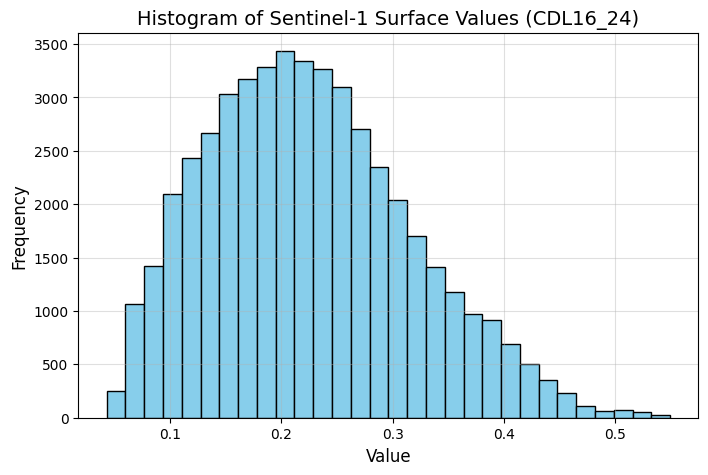

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example: if your array is already defined
# sentinel1_surface_y_CDL16_24 = np.load('your_array.npy')

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(HLSL30_surface_y_CDL16_24, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Sentinel-1 Surface Values (CDL16_24)', fontsize=14)
plt.grid(alpha=0.4)
plt.show()

In [ ]:
#@title re-organize to dataframe

# reorganize to 2-d array:
def get_time_index(initial_date, target_date):
    return int((target_date - initial_date).total_seconds() / 3600)

def DoY2Date(year, doy, hh=10):
    base_date = datetime(year, 1, 1, hour=hh)
    target_date = base_date + timedelta(days=(doy - 1))
    return target_date



def cdf_matching(source, target):
    sorted_target = np.sort(target)  # Target distribution sorted
    sorted_target_ranks = rankdata(sorted_target, method='average')
    sorted_target_quantiles = sorted_target_ranks / len(sorted_target)
    ranks = rankdata(source, method='average')  # Source data ranks
    percentiles = ranks / len(source)  # Percentile positions of source data
    matched_values = np.interp(percentiles, sorted_target_quantiles, sorted_target)  # Interpolation
    return matched_values



def CDF_maptching_and_reorganize_arr(ML1_sly_y_pred_all_arr, ML2_sly_y_pred_all_arr, ML3_sly_y_pred_all_arr, ML1_sly_info_arr, ML2_sly_info_arr, ML3_sly_info_arr, refer_id_arr):


    refer_id_idx_dict = {}
    for i in range(len(refer_id_arr)):
      refer_id_idx_dict[refer_id_arr[i]] = i


    ids = refer_id_arr
    len_id = len(ids)

    num_hours = 78912

    ML_sly_y_pred_arr = np.zeros((4, num_hours, len_id))
    ML_sly_y_pred_arr[:] = np.nan

    start_time = datetime(2016, 1, 1, 0)

    for i in range(len(ML1_sly_y_pred_all_arr)):
      t_idx = get_time_index(start_time, DoY2Date(int(ML1_sly_info_arr[i,  1]), int(ML1_sly_info_arr[i, 2]), int(ML1_sly_info_arr[i, 3])))
      id_idx = refer_id_idx_dict[int(ML1_sly_info_arr[i, 0])]
      ML_sly_y_pred_arr[0, t_idx, id_idx] = ML1_sly_y_pred_all_arr[i]


    for i in range(len(ML2_sly_y_pred_all_arr)):
      t_idx = get_time_index(start_time, DoY2Date(int(ML2_sly_info_arr[i,  1]), int(ML2_sly_info_arr[i, 2]), int(ML2_sly_info_arr[i, 3])))
      id_idx = refer_id_idx_dict[int(ML2_sly_info_arr[i, 0])]
      ML_sly_y_pred_arr[1, t_idx, id_idx] = ML2_sly_y_pred_all_arr[i]


    for i in range(len(ML3_sly_y_pred_all_arr)):
      t_idx = get_time_index(start_time, DoY2Date(int(ML3_sly_info_arr[i,  1]), int(ML3_sly_info_arr[i, 2]), int(ML3_sly_info_arr[i, 3])))
      id_idx = refer_id_idx_dict[int(ML3_sly_info_arr[i, 0])]
      ML_sly_y_pred_arr[2, t_idx, id_idx] = ML3_sly_y_pred_all_arr[i]


    for j in range(len_id):
      sentinel1_arr = ML_sly_y_pred_arr[0, :, j]
      sentinel2_arr = ML_sly_y_pred_arr[1, :, j]
      HLSL30_arr = ML_sly_y_pred_arr[2, :, j]

      sentinel1_nan_mask = np.isnan(sentinel1_arr)
      sentinel2_nan_mask = np.isnan(sentinel2_arr)
      HLSL30_nan_mask = np.isnan(HLSL30_arr)

      ML_sly_y_pred_arr[3, ~sentinel1_nan_mask, j] = cdf_matching(sentinel1_arr[~sentinel1_nan_mask], HLSL30_arr[~HLSL30_nan_mask])
      ML_sly_y_pred_arr[3, ~sentinel2_nan_mask, j] = cdf_matching(sentinel2_arr[~sentinel2_nan_mask], HLSL30_arr[~HLSL30_nan_mask])
      ML_sly_y_pred_arr[3, ~HLSL30_nan_mask, j] = HLSL30_arr[~HLSL30_nan_mask]


    return ML_sly_y_pred_arr





ML_sly_y_pred_arr = CDF_maptching_and_reorganize_arr(sentinel1_surface_y_CDL16_24, sentinel2_surface_y_CDL16_24, HLSL30_surface_y_CDL16_24,
                                                     sentinel1_surface_X_all_CDL16_24[:, :4], sentinel2_surface_X_all_CDL16_24[:, :4], HLSL30_surface_X_all_CDL16_24[:, :4],
                                                     referIDArr)
np.save('ML_sly_y_pred_arr_CDL16_24.npy', ML_sly_y_pred_arr)

ML_rly_y_pred_arr = CDF_maptching_and_reorganize_arr(sentinel1_rootzone_y_CDL16_24, sentinel2_rootzone_y_CDL16_24, HLSL30_rootzone_y_CDL16_24,
                                                     sentinel1_rootzone_X_all_CDL16_24[:, :4], sentinel2_rootzone_X_all_CDL16_24[:, :4], HLSL30_rootzone_X_all_CDL16_24[:, :4],
                                                     referIDArr)
np.save('ML_rly_y_pred_arr_CDL16_24.npy', ML_rly_y_pred_arr)

# import pandas as pd

# df_sentinel1_surface_CDL2016 = pd.DataFrame({
#     'ID': sentinel1_surface_X_all_CDL2016[:, 0],
#     'year': sentinel1_surface_X_all_CDL2016[:, 1],
#     'doy': sentinel1_surface_X_all_CDL2016[:, 2],
#     'hour': sentinel1_surface_X_all_CDL2016[:, 3],
#     'latitude': sentinel1_surface_X_all_CDL2016[:, 4],
#     'longitude': sentinel1_surface_X_all_CDL2016[:, 5],
#     'sm': sentinel1_surface_y_CDL2016[:],
#     'sensor': ['sentinel1'] * len(sentinel1_surface_y_CDL2016)
# })

# df_sentinel1_surface_CDL2016['date'] = pd.to_datetime(df_sentinel1_surface_CDL2016['year'].astype(int).astype(str) + df_sentinel1_surface_CDL2016['doy'].astype(int).astype(str), format='%Y%j')
# df_sentinel1_surface_CDL2016['month'] = df_sentinel1_surface_CDL2016['date'].dt.month
# df_sentinel1_surface_CDL2016['day'] = df_sentinel1_surface_CDL2016['date'].dt.day
# df_sentinel1_surface_CDL2016 = df_sentinel1_surface_CDL2016.drop(columns=['doy', 'date'])

# df_sentinel2_surface_CDL2016 = pd.DataFrame({
#     'ID': sentinel2_surface_X_all_CDL2016[:, 0],
#     'year': sentinel2_surface_X_all_CDL2016[:, 1],
#     'doy': sentinel2_surface_X_all_CDL2016[:, 2],
#     'hour': sentinel2_surface_X_all_CDL2016[:, 3],
#     'latitude': sentinel2_surface_X_all_CDL2016[:, 4],
#     'longitude': sentinel2_surface_X_all_CDL2016[:, 5],
#     'sm': sentinel2_surface_y_CDL2016[:],
#     'sensor': ['sentinel2'] * len(sentinel2_surface_y_CDL2016)
# })

# df_sentinel2_surface_CDL2016['date'] = pd.to_datetime(df_sentinel2_surface_CDL2016['year'].astype(int).astype(str) + df_sentinel2_surface_CDL2016['doy'].astype(int).astype(str), format='%Y%j')
# df_sentinel2_surface_CDL2016['month'] = df_sentinel2_surface_CDL2016['date'].dt.month
# df_sentinel2_surface_CDL2016['day'] = df_sentinel2_surface_CDL2016['date'].dt.day
# df_sentinel2_surface_CDL2016 = df_sentinel2_surface_CDL2016.drop(columns=['doy', 'date'])

# df_HLSL30_surface_CDL2016 = pd.DataFrame({
#     'ID': HLSL30_surface_X_all_CDL2016[:, 0],
#     'year': HLSL30_surface_X_all_CDL2016[:, 1],
#     'doy': HLSL30_surface_X_all_CDL2016[:, 2],
#     'hour': HLSL30_surface_X_all_CDL2016[:, 3],
#     'latitude': HLSL30_surface_X_all_CDL2016[:, 4],
#     'longitude': HLSL30_surface_X_all_CDL2016[:, 5],
#     'sm': HLSL30_surface_y_CDL2016[:],
#     'sensor': ['HLSL30'] * len(HLSL30_surface_y_CDL2016)
# })

# df_HLSL30_surface_CDL2016['date'] = pd.to_datetime(df_HLSL30_surface_CDL2016['year'].astype(int).astype(str) + df_HLSL30_surface_CDL2016['doy'].astype(int).astype(str), format='%Y%j')
# df_HLSL30_surface_CDL2016['month'] = df_HLSL30_surface_CDL2016['date'].dt.month
# df_HLSL30_surface_CDL2016['day'] = df_HLSL30_surface_CDL2016['date'].dt.day
# df_HLSL30_surface_CDL2016 = df_HLSL30_surface_CDL2016.drop(columns=['doy', 'date'])

# df_combined_surface_CDL2016 = pd.concat(
#     [df_sentinel1_surface_CDL2016, df_sentinel2_surface_CDL2016, df_HLSL30_surface_CDL2016],
#     ignore_index=True
# )

In [ ]:
# df_combined_surface_CDL2016.to_csv('df_combined_surface_CDL2016.csv', index=False)

## CDF matching - it seems one year is too short for CDF matching

In [ ]:
from scipy.stats import rankdata
import numpy as np
from datetime import datetime,timedelta
import pandas as pd

def cdf_matching(source, target):
    sorted_target = np.sort(target)  # Target distribution sorted
    sorted_target_ranks = rankdata(sorted_target, method='average')
    sorted_target_quantiles = sorted_target_ranks / len(sorted_target)
    ranks = rankdata(source, method='average')  # Source data ranks
    percentiles = ranks / len(source)  # Percentile positions of source data
    matched_values = np.interp(percentiles, sorted_target_quantiles, sorted_target)  # Interpolation
    return matched_values



def correct_2_ML3(Sentinel_sl_arr, sentinel2_sl_arr, hls_sl_arr, Sentinel_rly_arr, sentinel2_rly_arr, hls_rly_arr):
    Sentinel_sl_arr_ = Sentinel_sl_arr.copy()
    sentinel2_sl_arr_ = sentinel2_sl_arr.copy()
    hls_sl_arr_ = hls_sl_arr.copy()
    Sentinel_rly_arr_ = Sentinel_rly_arr.copy()
    sentinel2_rly_arr_ = sentinel2_rly_arr.copy()
    hls_rly_arr_ = hls_rly_arr.copy()
    # Xid_all, Xyear_all, Xdoy_all, Xutc_all, y_hat, y_up_hat, y_median_hat, y_low_hat

    # surface layer
    ids = list(set(sentinel2_sl_arr_[:, 0]))
    for idd in ids:
        hls_mask = hls_sl_arr_[:, 0] == idd
        Sentinel_mask = Sentinel_sl_arr_[:, 0] == idd
        sentinel2_mask = sentinel2_sl_arr_[:, 0] == idd
        print(f'sly, {idd} numbers: {np.count_nonzero(Sentinel_mask)}, {np.count_nonzero(sentinel2_mask)}, {np.count_nonzero(hls_mask)}')

        Sentinel_sl_arr_[Sentinel_mask, 4] = cdf_matching(Sentinel_sl_arr_[Sentinel_mask, 4], sentinel2_sl_arr_[sentinel2_mask, 4])
        hls_sl_arr_[hls_mask, 4] = cdf_matching(hls_sl_arr_[hls_mask, 4], sentinel2_sl_arr_[sentinel2_mask, 4])


    # rootzone
    ids = list(set(sentinel2_rly_arr_[:, 0]))
    for idd in ids:
        hls_mask = hls_rly_arr_[:, 0] == idd
        Sentinel_mask = Sentinel_rly_arr_[:, 0] == idd
        sentinel2_mask = sentinel2_rly_arr_[:, 0] == idd
        print(f'rly, {idd} numbers: {np.count_nonzero(Sentinel_mask)}, {np.count_nonzero(sentinel2_mask)}, {np.count_nonzero(hls_mask)}')

        Sentinel_rly_arr_[Sentinel_mask, 4] = cdf_matching(Sentinel_rly_arr_[Sentinel_mask, 4],
                                                          sentinel2_rly_arr_[sentinel2_mask, 4])
        hls_rly_arr_[hls_mask, 4] = cdf_matching(hls_rly_arr_[hls_mask, 4], sentinel2_rly_arr_[sentinel2_mask, 4])

    return Sentinel_sl_arr_, sentinel2_sl_arr_, hls_sl_arr_, Sentinel_rly_arr_, sentinel2_rly_arr_, hls_rly_arr_


In [ ]:
sentinel1_surface_id_arr = sentinel1_surface_X_all_CDL2016[:, 0]
sentinel1_rootzone_id_arr = sentinel1_rootzone_X_all_CDL2016[:, 0]
sentinel2_surface_id_arr = sentinel2_surface_X_all_CDL2016[:, 0]
sentinel2_rootzone_id_arr = sentinel2_rootzone_X_all_CDL2016[:, 0]
HLSL30_surface_id_arr = HLSL30_surface_X_all_CDL2016[:, 0]
HLSL30_rootzone_id_arr = HLSL30_rootzone_X_all_CDL2016[:, 0]

